## Финальный проект Deep Learning School (2 семестр, 2025) - "Video Dubbing"
### Введение

**Video dubbing** — процесс замены оригинальной звуковой дорожки видео на озвученную версию на другом языке, с сохранением естественности восприятия и максимальной точностью передачи смысла. В отличие от простого субтитрирования, дублирование позволяет сделать видео более доступным и погружающим для целевой аудитории, особенно в случаях, когда зритель не привык читать текст во время просмотра (например, дети, пожилые люди или носители языка без навыков чтения).

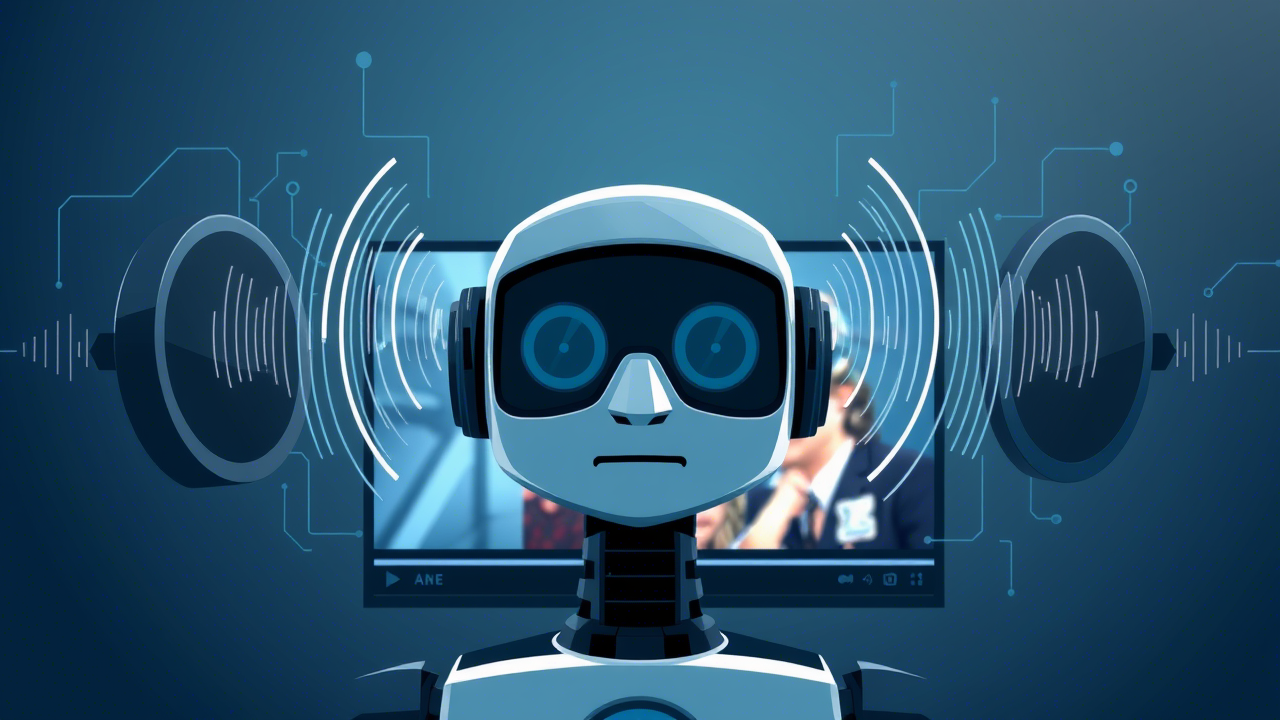

Традиционно процесс дублирования требует участия профессиональных актеров озвучивания, режиссеров, звукорежиссеров и занимает много времени и ресурсов. Однако развитие технологий искусственного интеллекта, в частности методов обработки естественного языка (NLP), синтеза речи (TTS — Text-to-Speech), распознавания речи (ASR — Automatic Speech Recognition) и машинного перевода (MT), позволило автоматизировать многие этапы этого процесса. Это открывает возможность создания качественного видео дублирования с минимальным человеческим участием, значительно снижая затраты и ускоряя производство.

Таким образом, разработка систем автоматического дублирования видео с английского на русский язык является актуальной задачей как с научной, так и с практической точки зрения. Она обеспечивает доступ к международному видеоконтенту для широкой русскоязычной аудитории, поддерживает локализацию образовательных, медицинских, корпоративных и развлекательных материалов, а также открывает новые возможности для бизнеса в сфере цифровых медиа и онлайн-образования.

## План реализации проекта
#### 1) Извлечение аудиодорожки из исходного видеоматериала и её предварительная обработка:
   - Извлечение звуковой дорожки из входного видеоролика в формате, пригодном для дальнейшей обработки;
   - Для улучшения качества распознавания и повышения точности транскрипции проводится комплексная предобработка звука:
     * Сепарация голоса и фона **(Demucs)**;
     * Шумоподавление;
     * Приведение к нормализованному формату.
#### 2) Транскрипция и временная сегментация речи (**Whisper - small**);
#### 3) Перевод текстовых сегментов на русский язык (**Facebook NLLB-200-distilled-600M**);
#### 4) Синтез речи и постпроцессинг аудиосегментов (**XTTS-v2 от Coqui TTS**);
#### 5) Микширование новой аудиодорожки с фоновым звуком;
#### 6) Интеграция озвученной аудиодорожки с видеофайлом;
#### 7) Дообучение модели синтеза речи на голосе Владимира Путина:
   - Для достижения более высокой степени реалистичности и персонализации разрабатывается процесс дообучения (fine-tuning) модели **XTTS-v2** на корпусе аудиозаписей официальных выступлений Президента Российской Федерации. Обучающий набор включает:
     * Выборку речевых фрагментов высокого качества;
     * Предварительную сегментацию и аннотирование данных;
     * Подготовку текстовых пар (текст–аудио) для обучения.
#### 9) Анализ качества и сравнение моделей.
#### 10) Итоги по проекту и шаги развития.

## 0. Импортируем необходимые библиотеки

In [1]:
import os
import gc
import shutil
import logging
from typing import NoReturn, Optional, Tuple, List, Dict, Any

from IPython.display import Audio
from IPython.display import display

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio

import subprocess

import noisereduce as nr
import pandas as pd
from pydub import AudioSegment
from pydub.effects import compress_dynamic_range
from scipy.io.wavfile import read, write

from tqdm.auto import tqdm
from dataclasses import dataclass
from copy import deepcopy
import whisper
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

from TTS.utils.manage import ModelManager
from TTS.tts.layers.xtts.trainer.gpt_trainer import XttsConfig
from TTS.tts.models.xtts import Xtts

from pydub.effects import speedup
from tempfile import NamedTemporaryFile
import soundfile as sf
import re
from sklearn.model_selection import train_test_split

from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.layers.xtts.trainer.gpt_trainer import XttsAudioConfig, GPTArgs, GPTTrainerConfig, GPTTrainer
from TTS.tts.datasets import load_tts_samples
from trainer import Trainer, TrainerArgs


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger(__name__)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Wed Jul  9 17:47:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             13W /  170W |     302MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

---
## 1. Преобработка видео и аудио (1 балл)

In [3]:
def print_directory_tree(start_path: str='./',
                         max_depth: int=4,
                         current_depth: int=0) -> NoReturn:
    """
    Рекурсивно выводит дерево каталогов до определенной глубины.
    
    Параметры:
        start_path (str): путь с которого начинается печать дерева
        max_depth (int): максимальное глубина дерева
        current_depth (int): текущая глубина пути
    """
    if current_depth > max_depth:
        return

    for root, dirs, files in os.walk(start_path):
        # Определяем уровень вложенности
        level = root.replace(start_path, "").count(os.sep)
        if level > max_depth:
            continue

        indent = '│   ' * (level - 1) + '├── ' if level > 0 else ''
        print(f"{indent}{os.path.basename(root)}" + "/")

        for file in sorted(files):
            print(f"{'│   ' * level}└── {file}")


def seed_torch(seed: int=42) -> NoReturn:
    """
    Фиксирует все seed по библиотекам random, os, numpy и torch для воспроизводимости результатов
    
    Параметры:
        seed (int): значение фиксации.
    """
    try:
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        logger.info(f"Все библиотеки зафиксированы с seed= {seed}")

    except Exception as e:
        logger.error(f"Фиксирование seed с ошибкой: {e}")


def manage_directory(directory_path: str='./',
                     action: str="create") -> NoReturn:
    """
    Создает или удаляет директорию по указанному пути.

    Параметры:
        directory_path (str): путь к директории.
        action (str): действие — 'create' для создания, 'delete' для удаления.

    Исключения:
        ValueError: если указано неверное действие.
    """
    if action == "create":
        os.makedirs(directory_path, exist_ok=True)
        logger.info(f"Директория '{directory_path}' успешно создана или уже существует.")
    
    elif action == "delete":
        if os.path.exists(directory_path):
            shutil.rmtree(directory_path)
            logger.info(f"Директория '{directory_path}' успешно удалена.")
        else:
            logger.info(f"Директория '{directory_path}' не существует.")
    
    else:
        raise ValueError("Неверное действие. Используйте 'create' или 'delete'.")

def create_path(dir_name: str='./', file_name: str='./') -> str:
    """
    Создает наименование пути

    Параметры:
        dir_name (str): наименование директории
        file_name (str): наименование файла
    Вовзращает:
        str: наименование созданного пути
    """
    try:
        path_name = os.path.join(dir_name, file_name)
        logger.info(F"Путь {path_name} создан.")
        return path_name
    except Exception as e:
        logger.error("Ошибка при создании наименования пути")
        return ""

In [4]:
# Фиксирование seed для воспроизводимости
SEED = 42
seed_torch(SEED)

# Обозначение глобальных переменных и создание путей
SUFFIX = 'woman'
INPUT_PATH = "./data/input/"
OUTPUT_PATH = "./data/output/"
ORIGINAL_VIDEO_PATH = create_path(INPUT_PATH, f"video_{SUFFIX}.mp4")

TEMP_DIR = create_path(OUTPUT_PATH, "temp")
ORIGINAL_AUDIO_PATH = create_path(TEMP_DIR, f"original_extracted_audio_{SUFFIX}.wav")

2025-07-09 17:47:29,660 - __main__ - INFO - Все библиотеки зафиксированы с seed= 42
2025-07-09 17:47:29,661 - __main__ - INFO - Путь ./data/input/video_woman.mp4 создан.
2025-07-09 17:47:29,662 - __main__ - INFO - Путь ./data/output/temp создан.
2025-07-09 17:47:29,662 - __main__ - INFO - Путь ./data/output/temp/original_extracted_audio_woman.wav создан.


In [5]:
# Отчищаем временную директорию

dir_for_create = [
#    OUTPUT_PATH,
    TEMP_DIR
]

for i in dir_for_create:
    manage_directory(i, action="delete")
    manage_directory(i, action="create")

2025-07-09 17:47:29,861 - __main__ - INFO - Директория './data/output/temp' успешно удалена.
2025-07-09 17:47:29,864 - __main__ - INFO - Директория './data/output/temp' успешно создана или уже существует.


### 1.1 Извлекаем аудио из видео
* Использем **FFmpeg** — инструмент для работы с видео и аудио. Через Python она запускает командную строку с нужными параметрами, чтобы выделить только звуковую дорожку из видео.
* Использем модуль **subprocess** — для запуска внешней команды (FFmpeg и других) из Python.

In [6]:
def extract_audio_from_video(video_path: str,
                             audio_path: str) -> NoReturn:
    """
    Извлекает аудиодорожку из видео с помощью FFmpeg.

    Параметры:
        video_path (str): путь к исходному видеофайлу
        audio_path (str): путь для сохранения аудиофайла (например, .wav или .mp3)

    Исключения:
        RuntimeError: если не удалось извлечь аудио
    """
    logger.info(f"Извлечение аудио из {video_path} → {audio_path}")

    if os.path.exists(audio_path):
        logger.info("Аудио уже существует, пропуск.")
        return

    os.makedirs(os.path.dirname(audio_path), exist_ok=True)

    cmd = [
        "ffmpeg",
        "-i", video_path,
        "-q:a", "0",
        "-map", "a",
        "-y",
        audio_path
    ]

    try:
        logger.debug(f"Выполняется команда: {' '.join(cmd)}")
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            check=True
        )
        logger.info("Аудио успешно извлечено из видео.")
    except subprocess.CalledProcessError as e:
        logger.error(f"Ошибка при извлечении аудио:\n{e.stdout}")
        raise RuntimeError(f"Не удалось извлечь аудио из видео: {e}")

In [7]:
extract_audio_from_video(ORIGINAL_VIDEO_PATH, ORIGINAL_AUDIO_PATH)

#wn = Audio(ORIGINAL_AUDIO_PATH, autoplay=False)
#display(wn)

2025-07-09 17:47:29,876 - __main__ - INFO - Извлечение аудио из ./data/input/video_woman.mp4 → ./data/output/temp/original_extracted_audio_woman.wav
2025-07-09 17:47:30,867 - __main__ - INFO - Аудио успешно извлечено из видео.


### 1.2.1 Разделяем аудио на стеммы (голос, фон, инструменты, барабаны и др.)
* Используем **Demucs** - является одной из самых популярных нейросетевых моделей для разделения источников звука (**source separation**). Это нейросеть, которая обучена разделять звук на отдельные дорожки: **вокал**, барабаны, бас, **остальное**.

##### Альтернативы:
1) **Spleeter** - библиотека от компании Deezer, основанная на TensorFlow, которая позволяет разделять звук на несколько дорожек: вокал, бас, барабаны, другие звуки.
    - **Пробовал!** Однако, учитывая, что она основана на TensorFlow - усложняет процесс синхронизации с PyTorch, а именно раздувая окружение ради одного процесса. Также проект уже активно не поддерживается и не развивается...
2) **Open-Unmix (UMX)** - модель, ориентированная на разделение музыкальных дорожек (например, отделение вокала от фоновой музыки).
    - Не пробовал.
3) **RIPPLE (Real-time Instrumental and Vocal Separation)** - модель для быстрого разделения на вокал и инструментал, оптимизированная под реальное время.
   - Не пробовал.
4) **MDX-Net (Melodia-based Deep Extractor Network)** - часть проекта UVR (Ultimate Vocal Remover GUI) — мощная система для разделения вокала и фона.
   - Не пробовал.
6) **LASS (Language-Aware Source Separation)** - экспериментальная модель, которая учитывает текст (ASR) при разделении речи.
   - Не пробовал.
---
Оставился на **Demcus**, так как вполне устроил вес модели, ее скорость и качество инференса.

In [8]:
def separate_audio_sources(
    input_audio_path: str,
    temp_dir: str,
    model_name: str = "htdemucs",
    output_format: str = "wav",
    device: str=DEVICE
    ) -> Tuple[str]:
    """
    Разделяет аудиофайл на голос и фоновые звуки с использованием Demucs.
    
    Параметры:
        input_audio_path (str): путь к исходному аудиофайлу.
        temp_dir (str): путь к временным файлам.
        model_name (str): модель Demucs для использования. По умолчанию 'htdemucs'.
        output_format (str): формат выходных файлов (например, 'wav', 'mp3').
        device (str): выбор ГПУ / ЦПУ

    Возвращает:
        Tuple[str]: кортеж из пути к голосу и фоновым звукам из аудио.
    """
    if not os.path.exists(input_audio_path):
        logger.error(f"Файл {input_audio_path} не найден.")

    output_dir = os.path.dirname(input_audio_path)

    try:

        cmd = [
            "demucs",
            "-n", model_name,
            "--out", output_dir,
            input_audio_path
        ]

        
        if device == 'cuda':
            cmd.append("-d")
            cmd.append(device)
            

        # Добавляем опции для формата
        if output_format == "mp3":
            cmd.append("--mp3")
        elif output_format == "flac":
            cmd.append("--flac")
        elif output_format != "wav":
            logger.warning(f"Неподдерживаемый формат: {output_format}. Используется WAV.")
            
        logger.info(f"Запуск команды: {' '.join(cmd)}")
        subprocess.run(cmd, check=True)

        # После выполнения перемещаем нужные дорожки
        base_name = os.path.splitext(os.path.basename(input_audio_path))[0]
        stems_dir = os.path.join(output_dir, model_name, base_name)

        # Перемещаем вокал и инструментал
        voice_source = create_path(stems_dir, "vocals.wav")
        background_source = create_path(stems_dir, "other.wav")

        if not os.path.exists(voice_source) or not os.path.exists(background_source):
            logger.error("Demucs не создал ожидаемые файлы (vocals.wav или other.wav).")

        output_voice_path = create_path(temp_dir, f"vocals_{SUFFIX}.wav")
        output_background_path = create_path(temp_dir, f"background_{SUFFIX}.wav")
        
        # Копируем или перемещаем файлы в целевые пути
        os.rename(voice_source, output_voice_path)
        os.rename(background_source, output_background_path)

        logger.info(f"Голос сохранён в: {output_voice_path}")
        logger.info(f"Фоновые звуки сохранены в: {output_background_path}")

        return (output_voice_path, output_background_path)
        
    except Exception as e: 
        logger.error(f"Ошибка: {e}")
        return ()

In [9]:
output_voice_path, output_background_path = separate_audio_sources(input_audio_path=ORIGINAL_AUDIO_PATH, temp_dir=TEMP_DIR)

2025-07-09 17:47:30,884 - __main__ - INFO - Запуск команды: demucs -n htdemucs --out ./data/output/temp ./data/output/temp/original_extracted_audio_woman.wav -d cuda


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /workspace/data/output/temp/htdemucs
Separating track data/output/temp/original_extracted_audio_woman.wav


100%|██████████████████████████████████████████████| 473.84999999999997/473.84999999999997 [00:14<00:00, 32.22seconds/s]
2025-07-09 17:47:52,331 - __main__ - INFO - Путь ./data/output/temp/htdemucs/original_extracted_audio_woman/vocals.wav создан.
2025-07-09 17:47:52,332 - __main__ - INFO - Путь ./data/output/temp/htdemucs/original_extracted_audio_woman/other.wav создан.
2025-07-09 17:47:52,337 - __main__ - INFO - Путь ./data/output/temp/vocals_woman.wav создан.
2025-07-09 17:47:52,338 - __main__ - INFO - Путь ./data/output/temp/background_woman.wav создан.
2025-07-09 17:47:52,349 - __main__ - INFO - Голос сохранён в: ./data/output/temp/vocals_woman.wav
2025-07-09 17:47:52,350 - __main__ - INFO - Фоновые звуки сохранены в: ./data/output/temp/background_woman.wav


### 1.2.2 Обрабатываем отделенный голос:
##### Напишем функция, которая готовит аудиофайл к распознаванию речи.

* Преобразует звук в нужный формат :
    - Устанавливает частоту дискретизации на 16000 Гц (стандарт для большинства ASR) (**pydub.AudioSegment**).
    - Делает аудио монофоническим (один канал вместо стерео) (**pydub.AudioSegment**).
    - Усиливает громкость , если голос слишком тихий (**pydub.AudioSegment**).
    - Убирает шумы , оставляя только чистую речь (**noisereduce**).
##### Альтернативы:
1) **RNNoise (Mozilla)** - очень качественная обработка шумов. **Пробовал!** Не понравилась тем, что сложные настройки и применение в общем пайплайне...
2) **DeepFilterNet** - усовершенствованная RNNoise. Не пробовал... Также сложная интеграция в пайплайн...
3) **SoX (Sound eXchange)** - имеет множество фильтров и эффектов. Не пробовал... К сожалению, автоматически уровень шума определять не умеет (необходим эталон).
---
Оставился на **noisereduce**, при правильном подборе параметров для работы со спикерами, выступающими на конференциях и публичных мероприятиях - очень хороший результат!

In [10]:
def preprocess_audio_for_asr(
    input_path: str,
    target_sample_rate: int = 16000,
    noise_reduce: bool = True,
    gain_increase: float = 10.0,
    prop_decrease: float = 0.75,       # ← доля подавления шума (меньше — осторожнее)
    n_fft: int = 512,
    hop_length: int = 512
) -> str:
    """
    Предобрабатывает аудиофайл для ASR: изменяет частоту, делает моно, применяет денойзинг и усиливает громкость.

    Параметры:
        input_path (str): путь к исходному аудиофайлу.
        target_sample_rate (int): целевая частота дискретизации.
        noise_reduce (bool): флаг необходимости удаления шума.
        gain_increase (float): усиление громкости в дБ.
        prop_decrease (float): степень подавления шума (от 0 до 1).
        n_fft (int): размер FFT для анализа спектра.
        hop_length (int): шаг между фреймами.

    Возвращает:
        str - путь к обработанному файлу.
    """
    if not os.path.exists(input_path):
        logger.error(f"Файл {input_path} не найден.")
        return ''

    output_dir = os.path.dirname(input_path)
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Конвертируем аудио в нужный формат
        audio = AudioSegment.from_file(input_path)

        # Повышаем громкость
        audio = audio.apply_gain(gain_increase)

        # Преобразуем в моно
        audio = audio.set_channels(1)

        # Изменяем частоту дискретизации
        audio = audio.set_frame_rate(target_sample_rate)

        # Сохраняем временный WAV
        temp_wav_path = create_path(output_dir, "temp_processed.wav")
        audio.export(temp_wav_path, format="wav")

        output_path = create_path(output_dir, f"vocals_processed_{SUFFIX}.wav")

        # Удаление шума
        if noise_reduce:
            rate, data = read(temp_wav_path)

            reduced_noise = nr.reduce_noise(
                y=data,
                sr=rate,
                prop_decrease=prop_decrease,
                n_fft=n_fft,
                hop_length=hop_length
            )

            # Сохраняем результат
            write(output_path, rate, reduced_noise.astype(np.int16))
        else:
            # Сохраняем без удаления шума
            audio.export(output_path, format="wav")

        os.remove(temp_wav_path)
        logger.info(f"Аудио успешно обработано и сохранено в: {output_path}")

        return output_path

    except Exception as e:
        logger.exception(f"Ошибка при предобработке аудио: {e}")
        return ''

In [11]:
output_voice_processed_path = preprocess_audio_for_asr(
    input_path=output_voice_path,
    target_sample_rate=16000,
    gain_increase=0.0,
    noise_reduce=True,
    prop_decrease=0.3,
    n_fft=512,
    hop_length=256
)

#wn = Audio(output_voice_processed_path, autoplay=False)
#display(wn)

2025-07-09 17:47:53,012 - __main__ - INFO - Путь ./data/output/temp/temp_processed.wav создан.
2025-07-09 17:47:53,068 - __main__ - INFO - Путь ./data/output/temp/vocals_processed_woman.wav создан.
2025-07-09 17:47:54,379 - __main__ - INFO - Аудио успешно обработано и сохранено в: ./data/output/temp/vocals_processed_woman.wav


---
## 2. Запуск ASR+MT модели (2 балла)

### 2.1 Транскрибация и сегментация речи:
##### Напишем функция, которая распознаёт речь на аудио и разбивает её на предложения, сохраняя временные метки начала и конца каждого слова и сегмента .

* Используем модель **Whisper** (small) как ASR-систему.
* Разделение на сегменты (по паузам). После получения списка слов с временными метками, функция делит текст на логические сегменты — предложения или фразы, разделённые паузами длиннее заданного порога. Данное решение позволяет:
  -  При синтезе речи не склеивать всё в один поток;
  -  Легче контролировать длительность сегментов;
  -  Сохранить естественную структуру речи.
* Сохранение референса:
 - Нужен чистый пример голоса без пауз и фоновых шумов для ZS клонирования голоса при генерации речи.

##### Альтернативы:
1) **Wav2Vec 2.0** - очень мощная модель ASR. Пробовал! Не поддерживает временные метки слов и сегментирование по спикерам...
2) **DeepSpeech (Mozilla)** - быстрая и легкая модель. Не пробовал... Устаревает и не очень активно поддерживается.
3) **Vosk API** - хорошая модель для русского языка, не тяжелая и быстрая. Не пробовал... Не очень работает с английским языком.
4) Вообще **пробовал** библиотеку **python-speech-to-text**, которая содержит в себе множество инструментов, включая и DeepSpeech, но по легкости и интеграции в пайплайн немного нагружена.
---
Оставился на **Whisper**. Очень крутая и мощная ASR модель с поддержкой множества языков, сегментацией по спикерам, временными метками по словам, несколькими вариациями моделей (base, small, medium и др.). Также можно ускорить с помощью **faster-whisper**, что я и сделал при интеграции в TG бота!

In [12]:
SPEAKER_REF_PATH = create_path(TEMP_DIR, f"speaker_ref_{SUFFIX}.wav")

@dataclass
class WordSegment:
    text: str
    start: float
    end: float


def transcribe_and_segment(
    model_asr,
    audio_path: str,
    max_pause_between_sentences: float = 1.5,
    max_audio_length_for_ref: float = 15.0,
    output_ref_path: str = "speaker_ref.wav"
) -> List[Dict[str, Any]]:
    """
    Транскрибирует аудио в текст с временными метками и сегментирует его на предложения.

    Параметры:
        model_asr: ASR-модель (например Whisper).
        audio_path (str): Путь к WAV-файлу.
        max_pause_between_sentences (float): Максимальная пауза между словами, после которой начинается новое предложение.
        max_audio_length_for_ref (float): Максимальная длина сегмента для референса (в секундах).
        output_ref_path (str): Путь, куда сохранить speaker_ref.wav.

    Возвращает:
        List[Dict[str, any]]: Список сегментов с текстом и временными метками.
    """
    try:
        # Копируем модель ASR
        model = model_asr

        # Загружаем аудиофайл целиком
        audio_data, sample_rate = sf.read(audio_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)  # моно

        # Транскрибируем с временными метками слов
        result = model.transcribe(
            audio_path,
            word_timestamps=True,
            task="transcribe"
        )

        # Извлекаем слова с временными метками
        words: List[WordSegment] = []
        for segment in result["segments"]:
            for word_info in segment.get("words", []):
                words.append(WordSegment(
                    text=word_info["word"],
                    start=word_info["start"],
                    end=word_info["end"]
                ))

        if not words:
            logger.error("Не найдено слов с временными метками.")
            return []

        # Сегментируем на предложения
        segments = []
        current_segment = {
            "text": "",
            "start": words[0].start,
            "end": words[0].end
        }

        for i in range(1, len(words)):
            word = words[i]
            prev_word = words[i - 1]

            # Если пауза больше порога — закрываем текущий сегмент
            if word.start - prev_word.end > max_pause_between_sentences:
                current_segment["text"] = current_segment["text"].strip()
                segments.append(current_segment)

                current_segment = {
                    "text": word.text,
                    "start": word.start,
                    "end": word.end
                }
            else:
                # Продолжаем текущий сегмент
                current_segment["text"] += " " + word.text
                current_segment["end"] = word.end

        # Добавляем последний сегмент
        current_segment["text"] = current_segment["text"].strip()
        segments.append(current_segment)

        logger.info(f"Создано {len(segments)} сегментов.")
        
        # Найдём самый длинный подходящий сегмент
        valid_segments = [seg for seg in segments if (seg["end"] - seg["start"]) <= max_audio_length_for_ref]
        if valid_segments:
            longest_segment = max(valid_segments, key=lambda x: x["end"] - x["start"])
            start_sample = int(longest_segment["start"] * sample_rate)
            end_sample = int(longest_segment["end"] * sample_rate)
            ref_audio = audio_data[start_sample:end_sample]

            sf.write(output_ref_path, ref_audio, sample_rate)
            logger.info(f"Референсное аудио сохранено как {output_ref_path}, длина: {end_sample / sample_rate:.2f} сек.")

        else:
            logger.warning("Не найдено подходящих сегментов для референса.")

        return segments

    except Exception as e:
        logger.error(f"Ошибка при транскрибации: {e}")
        return []

2025-07-09 17:47:54,391 - __main__ - INFO - Путь ./data/output/temp/speaker_ref_woman.wav создан.


In [13]:
WHISPER_NAME = 'small'
try:
    logger.info(f"Загрузка модели WHISPER: {WHISPER_NAME}")
    MODEL_ASR = whisper.load_model(name=WHISPER_NAME).to(DEVICE)
    logger.info("Модель ASR успешно загружена!")
except Exception as e:
    logger.error(f"Ошибка при загрузке ASR модели: {e}")

2025-07-09 17:47:54,399 - __main__ - INFO - Загрузка модели WHISPER: small
2025-07-09 17:47:56,673 - __main__ - INFO - Модель ASR успешно загружена!


In [14]:
segments = transcribe_and_segment(
    model_asr=MODEL_ASR,
    audio_path=output_voice_processed_path,
    max_pause_between_sentences=0.3,
    max_audio_length_for_ref=15,
    output_ref_path=SPEAKER_REF_PATH
    )

print(segments)

#wn = Audio(SPEAKER_REF_PATH, autoplay=False)
#display(wn)

2025-07-09 17:48:32,623 - __main__ - INFO - Создано 100 сегментов.
2025-07-09 17:48:32,636 - __main__ - INFO - Референсное аудио сохранено как ./data/output/temp/speaker_ref_woman.wav, длина: 454.58 сек.


[{'text': 'when  I  think  about  confidence,', 'start': 3.940000000000002, 'end': 5.92}, {'text': "I  first  ground  myself  in  the  definition.  Confidence  is  just  the  reliance  or  assurance  that  we  believe  in  someone's  abilities  or  qualities.", 'start': 6.52, 'end': 15.6}, {'text': "But  how  do  we  know  someone's  abilities  or  qualities?  How  does  anyone  believe  in  mine?", 'start': 16.34, 'end': 20.58}, {'text': "It's  simply  through  actions.", 'start': 21.34, 'end': 22.7}, {'text': "So  the  best  way  to  drive  and  build  confidence,  whether  we're  looking  to  hone  it  or  build  a  reputation  for  it,  or  in  confidence,  the  courage  people  to  have  it  in  us  is  to  drive  action.", 'start': 23.44, 'end': 33.34}, {'text': 'Interestingly,  many  people  think  you  need  a  lot  of  confidence  to  take  bold  action.', 'start': 34.339999999999996, 'end': 38.24}, {'text': 'I  think  the  opposite  is  true.', 'start': 38.9, 'end': 40.32}, {

### 2.1 Перевод сегментов с английского на русский язык:
##### Напишем функция, которая переводит текстовые сегменты с английского на русский.

* Используем **facebook/nllb-200-distilled-600M** модель - компактная версия модели NLLB (No Language Left Behind) от Meta/Facebook, которая хорошо справляется с переводом на уровне фраз и предложений.
* Используем pipeline из transformers с задачей translation.

##### Альтернативы:
1) **facebook/nllb-200-distilled-1.3B** - более мощный брат используемой. **Пробовал!** Справляется аналогично компактной версии, смысла перегружать диск не видел...
2) **Helsinki-NLP** - быстрая и легкая модель. **Пробовал**. Устаревает и очень плохо обрабатывала сегменты с точки зрения наполнения (пропускала часть предложений).
3) **Google Translate API** - прикольная штука, внедрял когда то в TG бота одного из проектов, живет до сих пор, но имеет куча ограничений (длина контекста, ответ от сервера и др.), так как все таки API.
4) **T5** - текст-к-текст модель, подходят для множества задач, включая перевод. Однако для хорошего перевода на русский явно нужно дообучение...
---
Оставился на **facebook/nllb-200-distilled-600M**. Хорошо справилась с задачей, однако есть одно **НО**! Перевод цельного текста выдает более осмысленный текст, чем перевод сегментов... К сожалению нужно адаптировать более неформальный перевод к временным меткам, пытался - пробовал, но такую речь потом пускать просто стримом лучше, иначе она скачет по скорости туда сюда...
* Сделал в TG боте отдельный функционал перевода текста с максимальной длиной 1024 (качество перевода выросло), можно еще более гибко разбивать на смысловые чанки (по косинусному расстроянию) и переводить их. Вопрос на подумать и на развитие!

In [15]:
def translate_segments(
    pipeline_mt,
    segments: List[Dict[str, any]],
    batch_size: int = 8
    ) -> List[Dict[str, any]]:
    """
    Переводит текстовые сегменты из одного языка в другой, сохраняя временные метки.

    Логика:
        1. Загружает модель перевода
        2. Обрабатывает пустые строки
        3. Применяет перевод к каждому сегменту
        4. Возвращает список сегментов вида {"text", "original_text", "start", "end"}

    Параметры:
        pipeline_mt: pipeline с предобученной моделью перевода с английского на русский
        segments (List[Dict]): список сегментов с ключами 'text', 'start', 'end'
        batch_size (int): размер батча сегментов для перевода

    Возвращает:
        List[Dict]: список сегментов с переводом
    """
    try:

        translator = pipeline_mt

        translated_segments = []

        texts_to_translate = [seg["text"].strip() for seg in segments]
        valid_indices = [i for i, text in enumerate(texts_to_translate) if text]

        if not valid_indices:
            logger.error("Нет текста для перевода.")
            return []

        logger.info(f"Переводим {len(valid_indices)} сегментов...")

        translated_texts = translator(
            [texts_to_translate[i] for i in valid_indices],
            batch_size=batch_size
        )

        # === Собираем результаты обратно в сегменты ===
        result_index = 0
        for i, segment in enumerate(segments):
            original_text = segment["text"].strip()
            if not original_text:
                continue

            translated_text = translated_texts[result_index]["translation_text"]
            result_index += 1

            translated_segments.append({
                "text": translated_text,
                "original_text": original_text,
                "start": segment["start"],
                "end": segment["end"]
            })

        logger.info(f"Переведено {len(translated_segments)} сегментов.")
        return translated_segments

    except Exception as e:
        logger.exception(f"Ошибка при переводе: {e}")
        return []

In [16]:
models_to_translate = {
    'fb_600m': 'facebook/nllb-200-distilled-600M',
    'fb_13b': 'facebook/nllb-200-distilled-1.3B'}

MODEL_MT_NAME = models_to_translate['fb_600m']
try:
    logger.info(f"Загрузка модели перевода: {MODEL_MT_NAME}")
    TOKENIZATOR_MT = AutoTokenizer.from_pretrained(MODEL_MT_NAME)
    MODEL_MT = AutoModelForSeq2SeqLM.from_pretrained(MODEL_MT_NAME).to(DEVICE)
    PIPELINE_MT = pipeline(
        task="translation",
        model=MODEL_MT,
        tokenizer=TOKENIZATOR_MT,
        src_lang="eng_Latn",
        tgt_lang="rus_Cyrl",
        max_length=1024,
        device=DEVICE)
    logger.info("Модель перевода загружена.")
except Exception as e:
    logger.error(f"Ошибка при загрузке модели перевода: {e}")

2025-07-09 17:48:32,653 - __main__ - INFO - Загрузка модели перевода: facebook/nllb-200-distilled-600M
2025-07-09 17:48:39,305 - __main__ - INFO - Модель перевода загружена.


In [17]:
translated_segments = translate_segments(
    pipeline_mt=PIPELINE_MT,
    segments=segments, 
    batch_size=12)

translated_segments

2025-07-09 17:48:39,318 - __main__ - INFO - Переводим 100 сегментов...
2025-07-09 17:48:48,736 - __main__ - INFO - Переведено 100 сегментов.


[{'text': 'Когда я думаю о уверенности,',
  'original_text': 'when  I  think  about  confidence,',
  'start': 3.940000000000002,
  'end': 5.92},
 {'text': 'В первую очередь я опираюсь на определение: уверенность - это просто уверенность в способностях или качествах кого-то.',
  'original_text': "I  first  ground  myself  in  the  definition.  Confidence  is  just  the  reliance  or  assurance  that  we  believe  in  someone's  abilities  or  qualities.",
  'start': 6.52,
  'end': 15.6},
 {'text': 'Но как мы узнаем о каких-то способностях или качествах?',
  'original_text': "But  how  do  we  know  someone's  abilities  or  qualities?  How  does  anyone  believe  in  mine?",
  'start': 16.34,
  'end': 20.58},
 {'text': 'Это просто через действия.',
  'original_text': "It's  simply  through  actions.",
  'start': 21.34,
  'end': 22.7},
 {'text': 'Поэтому лучший способ развить и развивать уверенность в себе, будь то усовершенствование или создание репутации, или уверенность, чтобы люди мо

---
## 3. Zero-shot генерация (2 балла)

### 3.1 Генерация аудио по сегментам:
##### Напишем функцию, которая генерирует текстовые сегменты на русском языке с учетом их временных меток. Для естественности используем некоторое количество постобработок.

* Используем **XTTS-v2 от Coqui AI** модель - одна из самых мощных моделей TTS на 2024 год. Генерирует речь с частотой дискретизации 24 кГц — очень высокое качество, а также поддерживает ZS клонирование голоса на небольших фрагментах.

##### Альтернативы:
1) **VITS** - очень качественная модель с плавной речью. Не пробовал... Может быть сильно лучше XTTS-v2, однако необходимо дообучение, не поддерживает ZS клонирования.
2) **FastSpeech / FastPitch** - быстрая и стабильная модель. Не пробовал... Хороша в реальном времени, однако не поддерживает клонирование голоса и хуже в интонациях...
3) **Tacotron 2** - одна из первых популярных моделей TTS. Не пробовал... Устаревает, не поддерживает клонирование голоса, медленная...
---
Оставился на **XTTS-v2 от Coqui AI** - ТЗ от авторов курса! Теперь расскажу как работает сама модель и что я делаю в пайплайне.
##### Модель состоит из нескольких ключевых частей, каждая из которых отвечает за определённый этап генерации:
* **Encoder**:
  - *Задача* : преобразует входной текст в последовательность лингвистических признаков.
  - Используется Transformer encoder .
  - Принимает на вход: текст, язык, фонемы.
  - Выход: скрытые представления текста (text embeddings).
* **Decoder**:
  - *Задача* : преобразует текстовые эмбеддинги в мел-спектрограммы.
  - Также использует Transformer decoder .
  - Может быть автогрегрессивным или параллельным (в зависимости от реализации).
  - Учитывает просодию, интонации, паузы.
* **Mel-Spectrogram Vocoder (например, HiFi-GAN)**:
  - *Задача* : преобразует мел-спектрограммы в волновой сигнал (WAV).
  - Это финальный этап, который превращает "картинку" речи в реальный звук.
  - Модель обучена воссоздавать высококачественный звук с минимальными искажениями.
* **Speaker Encoder / Embedding Network**:
  - *Задача* : извлекает уникальные характеристики голоса из аудиозаписи.
  - Это отдельная нейросеть (обычно типа ECAPA-TDNN), которая генерирует speaker embedding — вектор, описывающий тембр, тон, темп и другие особенности голоса.
  - В XTTS используется gpt_cond_latent — более продвинутая версия, которая учитывает не только тембр, но и просодию.
* **Prosody Encoder / GPT-style Latent Conditioner**:
  - *Задача* : кодирует интонационные и стилистические особенности речи.
  - Используется для передачи эмоций, темпа, акцента и других нюансов.
  - Представляет собой GPT-like latent conditioner , который помогает модели воспроизводить речь с нужной интонацией.
  - Эта часть называется gpt_cond_latent.
##### Теперь о пайплайне:
1) Сначала генерируются сегменты отдельно, сохраняя в названиях и словаре временные метки (начало-конец)
2) После начинается склеивание сегментов в один аудиофайл. Перед добавлением нового сегмента к уже накопленным:
   - проверяем первый это сегмент или нет, и двигаем его на +- аргумент влево, чтобы можно было начать чуть раньше (опережая оригинальную речь на несколько доли секунд)
   - перед добавлением нового сегмента, смотрим на оригинальную длительность и длительность сгенерированного, далее проверяем есть ли время до следующего сегмента и расширяем интервал, учитывая паузу между сегментами. Если все равно не успеваем, то ускоряем сегмент, учитывая границу ускорения.
   - ни в коем случае не обрезаем речь, а лишь двигаем сегмент чуть вправо на величинут аргумента.
   - между сегментами также можем применять fade in/out - для более плавного начала и окончания речи в сегменте (избавляемся от щелчков и неприятных резких звуков), а также crossfade между сегментами, для плавного и естественного соединения сегментов.
   - после получения финальной аудиодорожки дубляжа - применяем компрессию и нормализацию, чтобы не было перепадов и скачков в громкости и способствовало более естественному воспроизведению речи спикера.
     
**На развитие** - нужно быть более аккуратным с crossfade и настраивать его более тонко, так как он иногда может сработать в дублирование наложения текста и во-первых мы можем слышать будто эхо, а во-вторых ОЧЕНЬ редко но пол первый звук нового сегмента может пересекаться с последним звуком предыдущего... на общую картину это не влияет, однако естественность дубляжа пропадает. Слышал от каких то инструментах VAD и MFA для более точной синхронизации оригинальных сегментов и сгенерированных, однако не пробовал...

In [18]:
def download_missing_model_files(model_dir: str='./') -> Dict[str, str]:
    """
    Проверяет наличие необходимых файлов модели в model_dir.
    Если какого-то файла нет — загружает его.

    Параметры:
        model_dit (str): путь к модели

    Возвращает:
        Dict[str, str]: словарь с необходимыми файлами и путем к ним.
    """

    logger.info("Проверяем наличие файлов модели...")

    required_files = {
        "config.json": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/config.json",
        "model.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/model.pth",
        "vocab.json": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/vocab.json",
        "mel_stats.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/mel_stats.pth",
        "dvae.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/dvae.pth",
        "speakers_xtts.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/speakers_xtts.pth"
    }

    target_files = {}
    
    for fname, link in required_files.items():
        target_path = create_path(model_dir, fname)
        target_files[fname] = target_path
        if not os.path.isfile(target_path):
            logger.info(f"Файл {fname} отсутствует. Загружаем его...")
            ModelManager._download_model_files([link], model_dir, progress_bar=True)

            # Ищем загруженный файл
            found = False
            for f in os.listdir(model_dir):
                src = create_path(model_dir, f)
                if fname in f:
                    if src != target_path:
                        shutil.copy(src, target_path)
                    else:
                        logger.info(f"Файл {fname} уже находится в нужной папке")
                    found = True
                    break
                    
            if not found:
                raise FileNotFoundError(f"Не найден файл после загрузки: {fname}")
                return Dict[str, str]
                
        else:
            logger.info(f"Файл {fname} уже существует")

    return target_files

In [19]:
MODEL_TTS_DIR = './original_tts_model/'
manage_directory(MODEL_TTS_DIR, action='create')

LANGUAGE = "ru"

try:
    XTTS_FILES = download_missing_model_files(MODEL_TTS_DIR)
    logger.info("TTS модель загружена.")
except Exception as e:
    logger.error(f"Ошибка при загрузке модели xtts_v2: {e}")
    

2025-07-09 17:48:48,764 - __main__ - INFO - Директория './original_tts_model/' успешно создана или уже существует.
2025-07-09 17:48:48,765 - __main__ - INFO - Проверяем наличие файлов модели...
2025-07-09 17:48:48,765 - __main__ - INFO - Путь ./original_tts_model/config.json создан.
2025-07-09 17:48:48,767 - __main__ - INFO - Файл config.json уже существует
2025-07-09 17:48:48,768 - __main__ - INFO - Путь ./original_tts_model/model.pth создан.
2025-07-09 17:48:48,770 - __main__ - INFO - Файл model.pth уже существует
2025-07-09 17:48:48,770 - __main__ - INFO - Путь ./original_tts_model/vocab.json создан.
2025-07-09 17:48:48,772 - __main__ - INFO - Файл vocab.json уже существует
2025-07-09 17:48:48,772 - __main__ - INFO - Путь ./original_tts_model/mel_stats.pth создан.
2025-07-09 17:48:48,774 - __main__ - INFO - Файл mel_stats.pth уже существует
2025-07-09 17:48:48,775 - __main__ - INFO - Путь ./original_tts_model/dvae.pth создан.
2025-07-09 17:48:48,777 - __main__ - INFO - Файл dvae.pth

In [20]:
def generate_audio_segment(
    model_tts,
    segment: Dict[str, any],
    output_dir: str,
    speaker_wav: str,
    language: str
) -> Tuple[str, float]:
    """
    Генерирует аудио по сегменту.

    Параметры:
        model_tts: модель tts для синтеза речи и генерации сегментов.
        segment Dict[str, any]: сегмент типа {'text': str, 'start': float, 'end': float}.
        output_dir (str): путь для сохранения сегмента.
        speaker_wav (str): сегмент для референса при дальнейшей генерации и ZS клонировании.
        language (str): язык генерации.

    Возвращает:
        Tuple[str, float]: кортеж (путь к файлу, фактическая длительность в секундах)
    """
    logger.info(f"Генерация сегмента: '{segment['text']}'")

    with NamedTemporaryFile(suffix=".wav", delete=False) as tmpfile:
        temp_path = tmpfile.name

    gpt_cond_latent, speaker_embedding = model_tts.get_conditioning_latents(audio_path=speaker_wav)
    
    output = model_tts.inference(
        text=segment["text"],
        language=LANGUAGE,
        speaker_embedding=speaker_embedding,
        gpt_cond_latent=gpt_cond_latent
    )

    sf.write(temp_path, output["wav"], 24000)
    
    # Сохраняем как AudioSegment для дальнейшей обработки
    audio = AudioSegment.from_wav(temp_path)

    output_path = create_path(output_dir, f"seg_{int(segment['start'] * 1000)}.wav")
    audio.export(output_path, format="wav")

    os.remove(temp_path)

    return output_path, len(audio) / 1000

In [21]:
def synthesize_segments_with_timing(
    model_tts,
    segments: List[Dict[str, any]],
    output_audio_path: str,
    speaker_wav: str,
    language: str,
    max_speedup_factor: float = 2.0,
    min_pause_between_segments: float = 0.5,
    fade_in_out_ms: int = 50,
    crossfade_ms: int = 30,
    max_shift_left_seconds: float = 1.0,
    threshold_compression: float = -15.0,
    ratio_compression: float = 2.5,
    attack_compression: int = 10,
    release_compression: int = 70,
    target_dBFS: float = -16.0
) -> NoReturn:
    """
    Синтезирует дубляж с учётом временных меток оригинала.
    
    Логика:
        1. Каждый сегмент начинается не ранее original_start - max_shift_left_seconds.
        2. Полностью сохраняется текст — НЕ обрезается никогда.
        3. Если не вписываемся → ускоряем динамически, но не более чем max_speedup_factor.
        4. Сдвигаем следующий сегмент только вправо.
        5. Применяем кроссфейды между соседними сегментами для естественности.
        6. Все спецсимволы удаляются перед генерацией (.,!? и т.д.) - помогает избежать странных звуков при генерации.
        7. Финальная компрессия и нормализация всего аудио — для равномерной громкости.

    Параметры:
        model_tts: модель tts для синтеза речи и генерации сегментов.
        segments (List[Dict[str, any]]): список словарей с ключами 'text', 'start', 'end'
        output_audio_path (str): путь к выходному файлу
        speaker_wav (str): путь к образцу голоса для XTTS
        max_speedup_factor (float): максимальное ускорение, чтобы речь оставалась естественной
        min_pause_between_segments (float): минимальная пауза между фразами (в секундах)
        fade_in_out_ms (int): длительность fade-in/out (в мс)
        crossfade_ms (int): длительность кроссфеда между сегментами (в мс)
        max_shift_left_seconds (float): максимальный допустимый сдвиг влево (в секундах)
        threshold_compression (float): уровень сигнала в децибелах относительно максимума (dBFS), выше которого начинает работать компрессор (компрессор работает мягче , реже активируется.)
        ratio_compression (float): отношение "вход/выход" для сигналов выше порога (1.5:1 ... 3:1 — мягкое сжатие; 4:1 и выше — уже ближе к радио или подкастам)
        attack_compression (int): время в миллисекундах, за которое компрессор начинает реагировать на превышение порога (чем больше значение (например, 30 мс) → компрессор реагирует медленнее , оставляя начальный импульс звука нетронутым.)
        release_compression (int): время в миллисекундах, за которое компрессор возвращается к нормальному состоянию после того, как сигнал опускается ниже порога (Чем меньше значение (например, 20 мс) → компрессор быстрее «отпускает» сигнал → возможны слышимые изменения громкости.)
        target_dBFS (foat): целевой уровень громкости , к которому приводится аудиосигнал при нормализации
    """
    try:
        tts = deepcopy(model_tts)
        os.makedirs("./data/output/temp/audio_segments", exist_ok=True)

        full_duration_sec = max(seg["end"] for seg in segments) + 5
        full_audio = AudioSegment.silent(duration=int(full_duration_sec * 1000))

        # === Сохраняем оригинальный старт для каждого сегмента ===
        for i, segment in enumerate(segments):
            if "original_start" not in segment:
                segment["original_start"] = segment.get("start", 0.0)

        prev_end_time_sec = 0.0  # будем обновлять после каждого сегмента

        # === Цикл по всем сегментам ===
        for i, segment in tqdm(enumerate(segments)):
            original_start_sec = segment["original_start"]
            current_start_sec = segment["start"]
            current_start_ms = int(current_start_sec * 1000)

            # === Первый сегмент: проверяем, есть ли свободное время перед ним ===
            if i == 0:
                available_shift_left_for_first = max(0, original_start_sec - prev_end_time_sec)
                possible_shift_sec = min(available_shift_left_for_first, max_shift_left_seconds)

                if possible_shift_sec > 0.05:
                    logger.info(f"[{i}] Есть {available_shift_left_for_first:.2f} сек до первого сегмента → "
                                f"двигаем его влево на {possible_shift_sec:.2f} сек")
                    segment["start"] -= possible_shift_sec
                    segment["start"] = max(original_start_sec - max_shift_left_seconds, segment["start"])
                    current_start_sec = segment["start"]
                    current_start_ms = int(current_start_sec * 1000)

            # === Защита от слишком большого сдвига влево ===
            shift_seconds = current_start_sec - original_start_sec

            if shift_seconds < -max_shift_left_seconds:
                logger.warning(f"[{i}] Сегмент сдвинут слишком рано ({shift_seconds:.2f}s), "
                               f"восстанавливаем до {original_start_sec:.2f}s")
                segment["start"] = original_start_sec
                current_start_sec = original_start_sec
                current_start_ms = int(original_start_sec * 1000)
            elif shift_seconds < 0:
                logger.warning(f"[{i}] Сегмент сдвинут влево: оригинал {original_start_sec:.2f} → текущий {current_start_sec:.2f} сек")
            else:
                logger.info(f"[{i}] Сегмент начинается как и планировалось: {original_start_sec:.2f} → {current_start_sec:.2f} сек")

            # === Очистка текста перед генерацией ===
            raw_text = segment["text"]

            clean_text = raw_text.lower()
            clean_text = re.sub(r'[^\w\s]', '', clean_text)  # удаляем знаки препинания
            clean_text = re.sub(r'[\U00010000-\U0010ffff]', '', clean_text)  # удаляем эмодзи
            clean_text = re.sub(r'\s+', ' ', clean_text).strip()  # убираем лишние пробелы

            segment["cleaned_text"] = clean_text

            if not clean_text:
                logger.warning(f"[{i}] Сегмент после очистки стал пустым → пропускаем")
                continue

            # === Генерируем аудио ===
            seg_path, _ = generate_audio_segment(
                model_tts=tts,
                segment={**segment, "text": clean_text},
                output_dir="./data/output/temp/audio_segments",
                speaker_wav=speaker_wav,
                language=language
            )

            seg_audio = AudioSegment.from_wav(seg_path)
            generated_duration_ms = len(seg_audio)

            # === Получаем оригинальную длительность с защитой от start > end ===
            original_start_val = segment["start"]
            original_end_val = segment.get("end", segment["start"] + 1.0)

            if original_start_val > original_end_val:
                logger.warning(f"[{i}] start > end. Исправляем.")
                original_start_val, original_end_val = original_end_val, original_start_val
                segment["start"], segment["end"] = segment["end"], segment["start"]

            original_duration_ms = int((original_end_val - original_start_val) * 1000)
            logger.info(f"[{i}] Оригинальная длительность: {original_duration_ms / 1000:.2f} сек")
            logger.info(f"[{i}] Сгенерированная длительность: {generated_duration_ms / 1000:.2f} сек")

            # === Определяем доступное время до следующего сегмента ===
            if i < len(segments) - 1:
                next_start_sec = segments[i + 1]["start"]
                time_before_next_ms = max(0, int((next_start_sec - original_end_val) * 1000))
            else:
                time_before_next_ms = 0

            # === Вычисляем, сколько можно добавить к текущему сегменту ===
            available_extension_ms = max(
                0,
                time_before_next_ms - int(min_pause_between_segments * 1000)
            )
            extended_available_time_ms = max(100, original_duration_ms + available_extension_ms)

            logger.info(f"[{i}] Доступное время до следующего сегмента: {time_before_next_ms / 1000:.2f} сек")
            logger.info(f"[{i}] Можно увеличить на: {available_extension_ms / 1000:.2f} сек → "
                        f"теперь доступно: {extended_available_time_ms / 1000:.2f} сек")

            # === Проверяем, нужно ли ускорять ===
            corrected_audio = seg_audio
            applied_speedup = False

            if generated_duration_ms <= 0 or extended_available_time_ms <= 0:
                logger.warning(f"[{i}] Невозможно ускорить — нулевая длительность")
                corrected_duration_ms = generated_duration_ms
            elif generated_duration_ms > extended_available_time_ms:
                required_speedup = generated_duration_ms / extended_available_time_ms

                if required_speedup <= max_speedup_factor:
                    logger.info(f"[{i}] Применено ускорение {required_speedup:.2f}x чтобы уложиться в {extended_available_time_ms / 1000:.2f} сек")
                    corrected_audio = speedup(seg_audio, playback_speed=required_speedup)
                    corrected_duration_ms = int(generated_duration_ms / required_speedup)
                    applied_speedup = True
                else:
                    logger.warning(f"[{i}] Сегмент слишком длинный ({required_speedup:.2f}x), ограничиваем до {max_speedup_factor}x")
                    corrected_audio = speedup(seg_audio, playback_speed=max_speedup_factor)
                    corrected_duration_ms = int(generated_duration_ms / max_speedup_factor)
                    applied_speedup = True
            else:
                corrected_duration_ms = generated_duration_ms

            # === Применяем fade-in/out, но не нормализуем сейчас ===
            corrected_audio = corrected_audio.fade_in(fade_in_out_ms).fade_out(fade_in_out_ms)

            # === Сохраняем скорректированный аудио для кроссфейдов ===
            segment["corrected_audio"] = corrected_audio

            # === Вставляем по точному времени ===
            full_audio = full_audio[:current_start_ms] + corrected_audio + full_audio[current_start_ms + corrected_duration_ms:]

            actual_end_sec = current_start_sec + corrected_duration_ms / 1000
            segment["corrected_duration_sec"] = corrected_duration_ms / 1000
            logger.info(f"[{i}] Сегмент закончится на {actual_end_sec:.2f} сек")

            # === Обновляем начало следующего сегмента (только вправо!) ===
            if i < len(segments) - 1:
                next_segment = segments[i + 1]
                next_segment["original_start"] = next_segment.get("original_start", next_segment["start"])

                new_start_sec = actual_end_sec
                if new_start_sec < next_segment["original_start"]:
                    possible_shift_sec = next_segment["original_start"] - new_start_sec
                    if possible_shift_sec >= max_shift_left_seconds:
                        logger.warning(f"[{i+1}] Слишком большой сдвиг влево → используем оригинальный старт")
                        next_segment["start"] = next_segment["original_start"]
                    else:
                        logger.info(f"[{i+1}] Новый старт с допустимым сдвигом влево: {new_start_sec:.2f} сек")
                        next_segment["start"] = new_start_sec
                else:
                    next_segment["start"] = new_start_sec
                    logger.info(f"[{i+1}] Новый старт следующего сегмента: {next_segment['start']:.2f} сек")

        # === После всех сегментов применяем кроссфейды между соседними ===
        logger.info("Применяем кроссфейд между соседними сегментами...")
        for i in range(len(segments) - 1):
            curr_seg = segments[i]
            next_seg = segments[i + 1]

            curr_audio = curr_seg["corrected_audio"]
            next_audio = next_seg["corrected_audio"]

            curr_start_ms = int(curr_seg["start"] * 1000)
            next_start_ms = int(next_seg["start"] * 1000)

            overlap = curr_start_ms + len(curr_audio) - next_start_ms

            if 0 < overlap < crossfade_ms:
                logger.info(f"[{i}–{i+1}] Перекрытие {overlap} мс → применён кроссфейд на {overlap} мс")
                crossfaded = curr_audio.append(next_audio, crossfade=overlap)
                full_audio = full_audio[:curr_start_ms] + crossfaded + full_audio[curr_start_ms + len(crossfaded):]
            elif overlap >= crossfade_ms:
                logger.info(f"[{i}–{i+1}] Кроссфейд не применяется: перекрытие больше порога")
                pass
            else:
                full_audio = full_audio.overlay(next_audio, position=next_start_ms)

        # === Финальная обработка для равномерной громкости ===
        logger.info("Финальная обработка: компрессия + RMS-нормализация...")
        logger.info("Применяю компрессию динамического диапазона...")
        full_audio = compress_dynamic_range(
            full_audio,
            threshold=threshold_compression,
            ratio=ratio_compression,
            attack=attack_compression,
            release=release_compression
        )
        
        logger.info(f"Применяю RMS-нормализацию до {target_dBFS} dBFS...")
        change_in_dBFS = target_dBFS - full_audio.dBFS
        full_audio = full_audio.apply_gain(change_in_dBFS)

        # === Сохраняем финал ===
        full_audio.export(output_audio_path, format="wav")
        logger.info(f"Финальное аудио сохранено в: {output_audio_path}")

    except Exception as e:
        logger.error(f"Ошибка при синтезе аудио: {e}", exc_info=True)

In [22]:
try:
    logger.info("Инициализируем конфиг и модель XTTS")
    
    orig_config = XttsConfig()
    orig_config.load_json(XTTS_FILES['config.json'])
    
    ORIG_MODEL_TTS = Xtts.init_from_config(orig_config)
    ORIG_MODEL_TTS.load_checkpoint(
        orig_config,
        checkpoint_path=XTTS_FILES['model.pth'],
        vocab_path=XTTS_FILES['vocab.json'],
        speaker_file_path=XTTS_FILES['speakers_xtts.pth'],
        eval=True
    )

    ORIG_MODEL_TTS.to(DEVICE)
    
    logger.info("Модель XTTS успешно инициализированна")
except Exception as e:
    logger.error(f"Ошибка при инициализации модели XTTS: {e}")

2025-07-09 17:48:48,817 - __main__ - INFO - Инициализируем конфиг и модель XTTS
2025-07-09 17:49:06,042 - __main__ - INFO - Модель XTTS успешно инициализированна


In [23]:
FINAL_VOICE_PATH = create_path(OUTPUT_PATH, f"final_dubbing_{SUFFIX}.wav")

synthesize_segments_with_timing(
    model_tts=ORIG_MODEL_TTS,
    segments=translated_segments,
    output_audio_path=FINAL_VOICE_PATH,
    speaker_wav=SPEAKER_REF_PATH,
    language=LANGUAGE,
    max_speedup_factor=1.2,
    min_pause_between_segments=0.2,
    fade_in_out_ms=50,
    crossfade_ms=30,
    max_shift_left_seconds=0.5,
    threshold_compression=-15.0,
    ratio_compression=2.0,
    attack_compression=25,
    release_compression=50,
    target_dBFS=-15.0
)

#wn = Audio(FINAL_VOICE_PATH, autoplay=False)
#display(wn)

2025-07-09 17:49:06,049 - __main__ - INFO - Путь ./data/output/final_dubbing_woman.wav создан.
0it [00:00, ?it/s]2025-07-09 17:49:06,238 - __main__ - INFO - [0] Есть 3.94 сек до первого сегмента → двигаем его влево на 0.50 сек
2025-07-09 17:49:06,239 - __main__ - WARNING - [0] Сегмент сдвинут влево: оригинал 3.94 → текущий 3.44 сек
2025-07-09 17:49:06,240 - __main__ - INFO - Генерация сегмента: 'когда я думаю о уверенности'
2025-07-09 17:49:07,791 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_3440.wav создан.
2025-07-09 17:49:07,805 - __main__ - INFO - [0] Оригинальная длительность: 2.48 сек
2025-07-09 17:49:07,806 - __main__ - INFO - [0] Сгенерированная длительность: 2.18 сек
2025-07-09 17:49:07,807 - __main__ - INFO - [0] Доступное время до следующего сегмента: 0.60 сек
2025-07-09 17:49:07,808 - __main__ - INFO - [0] Можно увеличить на: 0.40 сек → теперь доступно: 2.88 сек
2025-07-09 17:49:07,873 - __main__ - INFO - [0] Сегмент закончится на 5.62 сек
2025-07-09 17:49

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:49:23,121 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_23100.wav создан.
2025-07-09 17:49:23,137 - __main__ - INFO - [4] Оригинальная длительность: 10.24 сек
2025-07-09 17:49:23,137 - __main__ - INFO - [4] Сгенерированная длительность: 13.46 сек
2025-07-09 17:49:23,138 - __main__ - INFO - [4] Доступное время до следующего сегмента: 1.00 сек
2025-07-09 17:49:23,138 - __main__ - INFO - [4] Можно увеличить на: 0.80 сек → теперь доступно: 11.04 сек
2025-07-09 17:49:23,139 - __main__ - WARNING - [4] Сегмент слишком длинный (1.22x), ограничиваем до 1.2x
2025-07-09 17:49:23,206 - __main__ - INFO - [4] Сегмент закончится на 34.32 сек
2025-07-09 17:49:23,207 - __main__ - INFO - [5] Новый старт с допустимым сдвигом влево: 34.32 сек
5it [00:16,  4.20s/it]2025-07-09 17:49:23,208 - __main__ - WARNING - [5] Сегмент сдвинут влево: оригинал 34.34 → текущий 34.32 сек
2025-07-09 17:49:23,209 - __main__ - INFO - Генерация сегмента: 'интересно что многие люди считают что дл

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:51:42,650 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_227040.wav создан.
2025-07-09 17:51:42,668 - __main__ - INFO - [54] Оригинальная длительность: 10.94 сек
2025-07-09 17:51:42,669 - __main__ - INFO - [54] Сгенерированная длительность: 14.44 сек
2025-07-09 17:51:42,669 - __main__ - INFO - [54] Доступное время до следующего сегмента: 0.40 сек
2025-07-09 17:51:42,670 - __main__ - INFO - [54] Можно увеличить на: 0.20 сек → теперь доступно: 11.14 сек
2025-07-09 17:51:42,671 - __main__ - WARNING - [54] Сегмент слишком длинный (1.30x), ограничиваем до 1.2x
2025-07-09 17:51:42,738 - __main__ - INFO - [54] Сегмент закончится на 239.07 сек
2025-07-09 17:51:42,739 - __main__ - INFO - [55] Новый старт следующего сегмента: 239.07 сек
55it [02:36,  4.47s/it]2025-07-09 17:51:42,740 - __main__ - INFO - [55] Сегмент начинается как и планировалось: 238.38 → 239.07 сек
2025-07-09 17:51:42,740 - __main__ - INFO - Генерация сегмента: 'и эти практики развились в наши дни 

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:52:27,913 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_298018.wav создан.
2025-07-09 17:52:27,929 - __main__ - INFO - [71] Оригинальная длительность: 7.92 сек
2025-07-09 17:52:27,930 - __main__ - INFO - [71] Сгенерированная длительность: 11.88 сек
2025-07-09 17:52:27,930 - __main__ - INFO - [71] Доступное время до следующего сегмента: 0.46 сек
2025-07-09 17:52:27,931 - __main__ - INFO - [71] Можно увеличить на: 0.26 сек → теперь доступно: 8.18 сек
2025-07-09 17:52:27,931 - __main__ - WARNING - [71] Сегмент слишком длинный (1.45x), ограничиваем до 1.2x
2025-07-09 17:52:27,982 - __main__ - INFO - [71] Сегмент закончится на 307.92 сек
2025-07-09 17:52:27,982 - __main__ - INFO - [72] Новый старт следующего сегмента: 307.92 сек
72it [03:21,  4.29s/it]2025-07-09 17:52:27,983 - __main__ - INFO - [72] Сегмент начинается как и планировалось: 306.40 → 307.92 сек
2025-07-09 17:52:27,984 - __main__ - INFO - Генерация сегмента: 'и так много членов команды которые пол

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:52:39,094 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_312444.wav создан.
2025-07-09 17:52:39,117 - __main__ - INFO - [73] Оригинальная длительность: 6.66 сек
2025-07-09 17:52:39,118 - __main__ - INFO - [73] Сгенерированная длительность: 11.98 сек
2025-07-09 17:52:39,119 - __main__ - INFO - [73] Доступное время до следующего сегмента: 0.40 сек
2025-07-09 17:52:39,119 - __main__ - INFO - [73] Можно увеличить на: 0.20 сек → теперь доступно: 6.85 сек
2025-07-09 17:52:39,120 - __main__ - WARNING - [73] Сегмент слишком длинный (1.75x), ограничиваем до 1.2x
2025-07-09 17:52:39,173 - __main__ - INFO - [73] Сегмент закончится на 322.43 сек
2025-07-09 17:52:39,174 - __main__ - INFO - [74] Новый старт следующего сегмента: 322.43 сек
74it [03:32,  5.13s/it]2025-07-09 17:52:39,175 - __main__ - INFO - [74] Сегмент начинается как и планировалось: 319.50 → 322.43 сек
2025-07-09 17:52:39,175 - __main__ - INFO - Генерация сегмента: 'потом я представила себе когото кого в

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:53:11,015 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_350633.wav создан.
2025-07-09 17:53:11,033 - __main__ - INFO - [82] Оригинальная длительность: 4.83 сек
2025-07-09 17:53:11,033 - __main__ - INFO - [82] Сгенерированная длительность: 18.48 сек
2025-07-09 17:53:11,034 - __main__ - INFO - [82] Доступное время до следующего сегмента: 0.64 сек
2025-07-09 17:53:11,035 - __main__ - INFO - [82] Можно увеличить на: 0.44 сек → теперь доступно: 5.27 сек
2025-07-09 17:53:11,035 - __main__ - WARNING - [82] Сегмент слишком длинный (3.51x), ограничиваем до 1.2x
2025-07-09 17:53:11,120 - __main__ - INFO - [82] Сегмент закончится на 366.03 сек
2025-07-09 17:53:11,121 - __main__ - INFO - [83] Новый старт следующего сегмента: 366.03 сек
83it [04:04,  5.74s/it]2025-07-09 17:53:11,122 - __main__ - INFO - [83] Сегмент начинается как и планировалось: 356.10 → 366.03 сек
2025-07-09 17:53:11,123 - __main__ - INFO - Генерация сегмента: 'это заставило меня думать о человеке к

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:53:20,684 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_366028.wav создан.
2025-07-09 17:53:20,702 - __main__ - INFO - [83] Оригинальная длительность: 2.93 сек
2025-07-09 17:53:20,703 - __main__ - INFO - [83] Сгенерированная длительность: 14.80 сек
2025-07-09 17:53:20,704 - __main__ - INFO - [83] Доступное время до следующего сегмента: 0.52 сек
2025-07-09 17:53:20,704 - __main__ - INFO - [83] Можно увеличить на: 0.32 сек → теперь доступно: 3.25 сек
2025-07-09 17:53:20,705 - __main__ - WARNING - [83] Сегмент слишком длинный (4.56x), ограничиваем до 1.2x
2025-07-09 17:53:20,777 - __main__ - INFO - [83] Сегмент закончится на 378.37 сек
2025-07-09 17:53:20,778 - __main__ - INFO - [84] Новый старт следующего сегмента: 378.37 сек
84it [04:14,  6.92s/it]2025-07-09 17:53:20,779 - __main__ - INFO - [84] Сегмент начинается как и планировалось: 369.48 → 378.37 сек
2025-07-09 17:53:20,779 - __main__ - INFO - Генерация сегмента: 'это заставило меня поблагодарить мужа 

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:53:30,335 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_378365.wav создан.
2025-07-09 17:53:30,353 - __main__ - INFO - [84] Оригинальная длительность: 2.87 сек
2025-07-09 17:53:30,353 - __main__ - INFO - [84] Сгенерированная длительность: 15.51 сек
2025-07-09 17:53:30,354 - __main__ - INFO - [84] Доступное время до следующего сегмента: 1.10 сек
2025-07-09 17:53:30,354 - __main__ - INFO - [84] Можно увеличить на: 0.90 сек → теперь доступно: 3.77 сек
2025-07-09 17:53:30,355 - __main__ - WARNING - [84] Сегмент слишком длинный (4.11x), ограничиваем до 1.2x
2025-07-09 17:53:30,424 - __main__ - INFO - [84] Сегмент закончится на 391.29 сек
2025-07-09 17:53:30,424 - __main__ - INFO - [85] Новый старт следующего сегмента: 391.29 сек
85it [04:24,  7.74s/it]2025-07-09 17:53:30,426 - __main__ - INFO - [85] Сегмент начинается как и планировалось: 382.34 → 391.29 сек
2025-07-09 17:53:30,426 - __main__ - INFO - Генерация сегмента: 'так вот это правило горячий удар и вы 

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-09 17:54:22,002 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_455958.wav создан.
2025-07-09 17:54:22,022 - __main__ - WARNING - [96] start > end. Исправляем.
2025-07-09 17:54:22,023 - __main__ - INFO - [96] Оригинальная длительность: 1.38 сек
2025-07-09 17:54:22,024 - __main__ - INFO - [96] Сгенерированная длительность: 15.65 сек
2025-07-09 17:54:22,024 - __main__ - INFO - [96] Доступное время до следующего сегмента: 0.00 сек
2025-07-09 17:54:22,025 - __main__ - INFO - [96] Можно увеличить на: 0.00 сек → теперь доступно: 1.38 сек
2025-07-09 17:54:22,026 - __main__ - WARNING - [96] Сегмент слишком длинный (11.36x), ограничиваем до 1.2x
2025-07-09 17:54:22,096 - __main__ - INFO - [96] Сегмент закончится на 469.00 сек
2025-07-09 17:54:22,097 - __main__ - INFO - [97] Новый старт следующего сегмента: 469.00 сек
97it [05:15,  5.88s/it]2025-07-09 17:54:22,098 - __main__ - INFO - [97] Сегмент начинается как и планировалось: 455.34 → 469.00 сек
2025-07-09 17:54:22,099 -

### 3.2 Микширование аудио дорожек и склеивание к видео:
##### Напишем функцию, которая смешивает три аудиодорожки для получения финального аудио и интеграции его в видео.
* Дубляж (voice_over) - сгенерированная речь на русском языке.
* Фоновая музыка или шумы (background) — то, что было отделено от голоса на этапе разделения моделью demucs.
* Оригинал (опционально) — можно добавить оригинальную дорожку как фон для сохранения атмосферы.
  - Из параметров здесь только настройка громкостей каждой из дорожек

In [24]:
def mix_audio_tracks(
    voice_over_path: str,
    background_path: str,
    output_path: str,
    original_audio_path: Optional[str] = None,
    voice_gain: float = 0.0,
    background_gain: float = -10.0,
    original_gain: float = -16.0
) -> str:
    """
    Смешивает дубляж, фоновую музыку и оригинал с помощью pydub.

    Параметры:
        voice_over_path: путь к русскоязычному дубляжу
        background_path: путь к фоновой музыке/шуму
        original_audio_path: путь к оригинальному аудио (опционально)
        voice_gain: громкость дубляжа
        background_gain: громкость фона
        original_gain: громкость оригинала

    Возвращает:
        str: путь к смикшированному файлу
    """
    logger.info("Загрузка аудиодорожек...")

    # Загружаем дорожки
    voice_audio = AudioSegment.from_wav(voice_over_path).apply_gain(voice_gain)
    background_audio = AudioSegment.from_wav(background_path).apply_gain(background_gain)

    # Создаём фон нужной длины
    max_duration = len(voice_audio)
    background_audio = (background_audio * (max_duration // len(background_audio) + 2))[:max_duration]

    # Накладываем дубляж на фон
    full_audio = background_audio.overlay(voice_audio)

    # Если есть оригинал — добавляем его как фон
    if original_audio_path and os.path.exists(original_audio_path):
        original_audio = AudioSegment.from_wav(original_audio_path).apply_gain(original_gain)
        full_audio = full_audio.overlay(original_audio)


    # Сохраняем результат
    full_audio.export(output_path, format="wav")
#    os.remove(voice_over_path)
    logger.info(f"Аудио смикшировано и сохранено: {output_path}")

    return output_path

In [25]:
FINAL_MIX_AUDIO_PATH = create_path(OUTPUT_PATH, f"final_mix_{SUFFIX}.wav")

mixed_audio_path = mix_audio_tracks(
    voice_over_path=FINAL_VOICE_PATH,
    background_path=output_background_path,
    output_path=FINAL_MIX_AUDIO_PATH,
    original_audio_path=ORIGINAL_AUDIO_PATH,
    voice_gain=-3.0,          # чуть ниже
    background_gain=-5.0,    # фон ниже
    original_gain=-10.0      # оригинал совсем тихий
)

#wn = Audio(mixed_audio_path, autoplay=False)
#display(wn)

2025-07-09 17:55:08,269 - __main__ - INFO - Путь ./data/output/final_mix_woman.wav создан.
2025-07-09 17:55:08,270 - __main__ - INFO - Загрузка аудиодорожек...
2025-07-09 17:55:09,701 - __main__ - INFO - Аудио смикшировано и сохранено: ./data/output/final_mix_woman.wav


### 3.3 Добавление финальной аудиодорожки к видео:
##### Напишем функцию, которая интегрирует финальный дубляж к оригинальному видео.
* Используются те же инструменты (FFmeg и subprocess), что и при извлечении аудио из видео

In [26]:
def add_audio_to_video(
    video_path: str,
    audio_path: str,
    output_video_path: str
) -> NoReturn:
    """
    Добавляет аудиодорожку к видео через FFmpeg.

    Параметры:
        video_path: путь к исходному видео
        audio_path: путь к новому аудиофайлу
        output_video_path: путь к выходному видео
    """
    logger.info("Добавление аудио к видео...")

    # Проверяем наличие файлов
    if not os.path.exists(video_path):
        logger.error(f"Видео не найдено: {video_path}")
        raise FileNotFoundError(f"Видео не найдено: {video_path}")

    if not os.path.exists(audio_path):
        logger.error(f"Аудиофайл не найден: {audio_path}")
        raise FileNotFoundError(f"Аудиофайл не найден: {audio_path}")

    # Подготовка директории для выходного файла
    os.makedirs(os.path.dirname(output_video_path), exist_ok=True)

    # Команда FFmpeg
    cmd = [
        "ffmpeg",
        "-i", video_path,
        "-i", audio_path,
        "-c:v", "copy",
        "-map", "0:v:0",
        "-map", "1:a:0",
        "-shortest",
        "-y",  # перезапись без вопросов
        output_video_path
    ]

    try:
        logger.info(f"Выполняется команда: {' '.join(cmd)}")
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        os.remove(audio_path)
        logger.info(f"Видео сохранено: {output_video_path}")
    except subprocess.CalledProcessError as e:
        logger.error(f"Ошибка при обработке видео: {e.stdout.decode()}")
        raise RuntimeError("Не удалось добавить аудио к видео")

In [27]:
FINAL_VIDEO_PATH = create_path(OUTPUT_PATH, f"final_video_{SUFFIX}.mp4")

add_audio_to_video(
    video_path=ORIGINAL_VIDEO_PATH,
    audio_path=FINAL_MIX_AUDIO_PATH,
    output_video_path=FINAL_VIDEO_PATH
)

2025-07-09 17:55:09,722 - __main__ - INFO - Путь ./data/output/final_video_woman.mp4 создан.
2025-07-09 17:55:09,723 - __main__ - INFO - Добавление аудио к видео...
2025-07-09 17:55:09,727 - __main__ - INFO - Выполняется команда: ffmpeg -i ./data/input/video_woman.mp4 -i ./data/output/final_mix_woman.wav -c:v copy -map 0:v:0 -map 1:a:0 -shortest -y ./data/output/final_video_woman.mp4
2025-07-09 17:55:13,714 - __main__ - INFO - Видео сохранено: ./data/output/final_video_woman.mp4


---
## 4. Файнтюнинг xtts_v2 модели под голос В.В. Путина (3 балла)

### 4.1 Создание выборки для дообучения.
1) Нам необходимо из выбранного нами видео получить аудиозапись, извлечь голос, предобработать его и подать модели ASR для транскрипции (аналогичные шаги предыдущих частей).
2) Создать metadata в котором будут записаны пара (текст-аудио), а также метаданные - язык, гендер и наименование спикера (требуется для XTTS).
---
**Спикером** для дообучения был взят голос президента Российской Федерации **Владимира Владимировича Путина**. А именно видео поздравление выпускников с окончанием обучения.

In [28]:
SUFFIX = 'putin'

DATASET_PATH = f"./data/{SUFFIX}"
ORIGINAL_FINE_VIDEO_PATH = os.path.join(INPUT_PATH, f"video_{SUFFIX}.mp4")
ORIGINAL_FINE_AUDIO_PATH = os.path.join(TEMP_DIR, f"original_extracted_audio_{SUFFIX}.wav")

dir_for_create = [DATASET_PATH]
for i in dir_for_create:
#    manage_directory(i, action="delete")
    manage_directory(i, action="create")

2025-07-09 17:55:13,727 - __main__ - INFO - Директория './data/putin' успешно создана или уже существует.


In [29]:
extract_audio_from_video(ORIGINAL_FINE_VIDEO_PATH, ORIGINAL_FINE_AUDIO_PATH)

#wn = Audio(ORIGINAL_FINE_AUDIO_PATH, autoplay=False)
#display(wn)

2025-07-09 17:55:13,733 - __main__ - INFO - Извлечение аудио из ./data/input/video_putin.mp4 → ./data/output/temp/original_extracted_audio_putin.wav
2025-07-09 17:55:14,075 - __main__ - INFO - Аудио успешно извлечено из видео.


In [30]:
output_fine_voice_path, _ = separate_audio_sources(input_audio_path=ORIGINAL_FINE_AUDIO_PATH, temp_dir=TEMP_DIR)

2025-07-09 17:55:14,084 - __main__ - INFO - Запуск команды: demucs -n htdemucs --out ./data/output/temp ./data/output/temp/original_extracted_audio_putin.wav -d cuda


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /workspace/data/output/temp/htdemucs
Separating track data/output/temp/original_extracted_audio_putin.wav


100%|██████████████████████████████████████████████████████████████████████| 181.35/181.35 [00:06<00:00, 29.44seconds/s]
2025-07-09 17:55:24,108 - __main__ - INFO - Путь ./data/output/temp/htdemucs/original_extracted_audio_putin/vocals.wav создан.
2025-07-09 17:55:24,108 - __main__ - INFO - Путь ./data/output/temp/htdemucs/original_extracted_audio_putin/other.wav создан.
2025-07-09 17:55:24,115 - __main__ - INFO - Путь ./data/output/temp/vocals_putin.wav создан.
2025-07-09 17:55:24,116 - __main__ - INFO - Путь ./data/output/temp/background_putin.wav создан.
2025-07-09 17:55:24,124 - __main__ - INFO - Голос сохранён в: ./data/output/temp/vocals_putin.wav
2025-07-09 17:55:24,125 - __main__ - INFO - Фоновые звуки сохранены в: ./data/output/temp/background_putin.wav


In [31]:
SAMPLE_RATE = 22050

output_fine_voice_processed_path = preprocess_audio_for_asr(
    input_path=output_fine_voice_path,
    target_sample_rate=SAMPLE_RATE,
    gain_increase=5.0,
    noise_reduce=True,
    prop_decrease=0.3,
    n_fft=512,
    hop_length=256
)

2025-07-09 17:55:24,349 - __main__ - INFO - Путь ./data/output/temp/temp_processed.wav создан.
2025-07-09 17:55:24,377 - __main__ - INFO - Путь ./data/output/temp/vocals_processed_putin.wav создан.
2025-07-09 17:55:24,908 - __main__ - INFO - Аудио успешно обработано и сохранено в: ./data/output/temp/vocals_processed_putin.wav


In [32]:
SPEAKER_REF_VER0 = create_path(DATASET_PATH, f'speaker_ref_{SUFFIX}.wav')

fine_segments = transcribe_and_segment(
    model_asr=MODEL_ASR,
    audio_path=output_fine_voice_processed_path,
    max_pause_between_sentences=0.7,
    output_ref_path=SPEAKER_REF_VER0
)

fine_segments

2025-07-09 17:55:24,915 - __main__ - INFO - Путь ./data/putin/speaker_ref_putin.wav создан.
2025-07-09 17:55:37,659 - __main__ - INFO - Создано 21 сегментов.
2025-07-09 17:55:37,685 - __main__ - INFO - Референсное аудио сохранено как ./data/putin/speaker_ref_putin.wav, длина: 171.50 сек.


[{'text': 'выпускники,', 'start': 0.0, 'end': 1.1},
 {'text': 'друзья,', 'start': 1.86, 'end': 2.06},
 {'text': 'от  всей  души  хочу  поздравить  вас,',
  'start': 3.04,
  'end': 4.86},
 {'text': 'ваших  родных  и  наставников,  с  особенным  неповторимым  и  очень  волнующим  праздником.  Вы  прощаетесь  со  школы,  вступаете  в  новый,  пока  неизвенанный  этап  жизни.',
  'start': 5.64,
  'end': 16.74},
 {'text': 'И  вместе  с  друзьями  мечтаете,  строите  планы,  кем  стать,  каких  вершин  добиться.  Дорога  к  ним  потребует  упорство,  готовности  работать  на  результат,',
  'start': 17.68,
  'end': 28.92},
 {'text': 'ответственности.', 'start': 29.64, 'end': 30.72},
 {'text': 'Не  сомневаюсь,  вас  есть  эти  качества,  и  вы  непременно  осуществуйте  свои  мечты.  Главное  –  верить  в  себя  и  помнить  любой  личный  успех,  обретает  особый  смысл,  когда  твой  труд  приносит  пользу  людям.  Нужен  родной  стране.  А  сегодня  вы,  уверен,  говорите  искренне,  идущие

In [33]:
# Путь к данным
WAVS_PATH = create_path(DATASET_PATH, "wavs")
METADATA_PATH = create_path(DATASET_PATH, "metadata.csv")
METADATA_VAL_PATH = create_path(DATASET_PATH, "metadata_val.csv")

# Путь для сохранения модели
FINETUNE_OUTPUT_PATH = "./xtts_finetune"


# Создаем директорию под сегменты
manage_directory(WAVS_PATH, action='create')

2025-07-09 17:55:37,693 - __main__ - INFO - Путь ./data/putin/wavs создан.
2025-07-09 17:55:37,695 - __main__ - INFO - Путь ./data/putin/metadata.csv создан.
2025-07-09 17:55:37,696 - __main__ - INFO - Путь ./data/putin/metadata_val.csv создан.
2025-07-09 17:55:37,700 - __main__ - INFO - Директория './data/putin/wavs' успешно создана или уже существует.


In [34]:
# Загружаем аудио
audio = AudioSegment.from_wav(output_fine_voice_processed_path)

# Проходим по списку сегментов
for i, segment in tqdm(enumerate(fine_segments)):
    start_time = float(segment['start']) * 1000  # в миллисекундах
    end_time = float(segment['end']) * 1000
    text = segment['text'].strip()

    # Обрезаем аудио
    chunk = audio[start_time:end_time]
    chunk.export(f"{WAVS_PATH}/audio_{i}.wav", format="wav")

21it [00:00, 112.75it/s]


In [35]:
# --- Создание metadata.csv ---

metadata = []
for i, seg in tqdm(enumerate(fine_segments)):
    wav_path = f"audio_{i}.wav"
    full_wav_path = os.path.join(WAVS_PATH, wav_path)
    
    # Здесь можно проверить существование файла
    if not os.path.isfile(full_wav_path):
        logger.info(f"Файл {full_wav_path} отсутствует")
        continue
    
    metadata.append({
        "audio_file": wav_path.split(".")[0],
        "text": seg["text"].strip(),
        "gender": "male",  # или male / neutral
        "language": "ru",
        "speaker_name": SUFFIX
    })

df = pd.DataFrame(metadata)
df.head(2)

21it [00:00, 773.68it/s]


,audio_file,text,gender,language,speaker_name
0,audio_0,"выпускники,",male,ru,putin
1,audio_1,"друзья,",male,ru,putin


In [36]:
df[["audio_file", "text", "gender", "language", "speaker_name"]].to_csv(
    METADATA_PATH, sep="|", index=False, header=None
)


logger.info(f"\nmetadata.csv создан: {METADATA_PATH}")

2025-07-09 17:55:37,992 - __main__ - INFO - 
metadata.csv создан: ./data/putin/metadata.csv


In [37]:
for i in tqdm(range(len(metadata))):
    wav_path = os.path.join(DATASET_PATH, "wavs", f"audio_{i}.wav")
    if not os.path.isfile(wav_path):
        raise FileNotFoundError(f"Файл {wav_path} не найден!")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 844.90it/s]


### 4.2 Дообучение модели XTTS_v2.
##### Нам необходимо:
1) Перенести модель в необходимую директорию, куда потом перезапишеться флучшая модель и конфиг.
2) Написать / адаптировать функцию дообучения модели XTTS.
3) Перенести обновленные файлы в директорию.
4) Сгенерировать те же сегменты, что и в предыдущей части.
5) Сохранить видео с дублежом дообученной модели.
---
##### За основу кода был взят пример из scripts/utils/**gpt_train.py** репозитория: https://github.com/daswer123/xtts-webui/tree/main и **адаптирован** для нашей задачи!

##### Настройка параметров датасета и обучения
* Используются следующие библиотечные классы:

    - BaseDatasetConfig — указывает путь к данным и файлам метаданных.
    - XttsAudioConfig — настройки аудио (частота дискретизации, форматы).
    - GPTArgs — параметры GPT-модели внутри XTTS.
    - 
* Тренировочный конфиг (GPTTrainerConfig), который определяет (основные компоненты):

    - Количество эпох,
    - Размер батча,
    - Оптимизатор,
    - Learning rate,
    - LR scheduler,
    - Логирование,
    - Сохранение чекпоинтов.
---
* Было проведено **несколько** экспериментов, здесь оставил самый удачный.
    - менял LR scheduler, параметры оптимизатора, Learning rate...
        - При супер маленьком шаге обучения loss скатывался в Nan и обучение прекращалось на 3й эпохе.
        - При LR scheduler == MultiStepLR, обучение шло медленнее и сходимость достигалась дольше... Да и не 10 эпохе можно было заметить разницу в avg_loss, данный планировщик сильно проигрывал
    - менял речь президента, брал не официальные поздравления, а вырезки, где он довольно таки быстро разговаривает...
        - данный помог при генерации быстроговорящих сегментов, однако исказил и не уловил тембр спикера. (то есть генерация одного и того же сегмента при разных дообученных моделях, отличалась скорость и диктция сгенерированных текстов)
---
**Развитие** - куда бы я посмотрел - это дообучение VITS, прям на официальных репозиториях от Сoqui, они приводят в пример дообучение этой модели. И ее качество при дообучении выше, чем у дообученной XTTS. Также наверное бы попробовал пересобрать обучающее множество, чтобы туда и быстрая и медленная речь входила, возможно выделить отдельно валидационное множество из другого видео но с тем же спикером.

In [38]:
# --- Пути ---
TRAIN_CSV = "metadata.csv"

# --- Гиперпараметры ---
NUM_EPOCHS = 100
BATCH_SIZE = 8
GRAD_ACUMM_STEPS = 1
MAX_SEC = 15
MAX_AUDIO_LENGTH = SAMPLE_RATE * MAX_SEC

READY_MODEL_PATH = "./finetuned_tts_model"
manage_directory(READY_MODEL_PATH, action='create')

2025-07-09 17:55:38,032 - __main__ - INFO - Директория './finetuned_tts_model' успешно создана или уже существует.


In [39]:
logger.info("Содержимое папки:")
for f in os.listdir(MODEL_TTS_DIR):
    logger.info(f" -{f}")

2025-07-09 17:55:38,038 - __main__ - INFO - Содержимое папки:
2025-07-09 17:55:38,040 - __main__ - INFO -  -config.json
2025-07-09 17:55:38,041 - __main__ - INFO -  -dvae.pth
2025-07-09 17:55:38,042 - __main__ - INFO -  -mel_stats.pth
2025-07-09 17:55:38,042 - __main__ - INFO -  -model.pth
2025-07-09 17:55:38,043 - __main__ - INFO -  -speakers_xtts.pth
2025-07-09 17:55:38,043 - __main__ - INFO -  -vocab.json


In [40]:
logger.info("Содержимое папки:")
for f in os.listdir(READY_MODEL_PATH):
    logger.info(f" -{f}")

2025-07-09 17:55:38,048 - __main__ - INFO - Содержимое папки:
2025-07-09 17:55:38,051 - __main__ - INFO -  -best_model.pth
2025-07-09 17:55:38,053 - __main__ - INFO -  -config.json
2025-07-09 17:55:38,053 - __main__ - INFO -  -dvae.pth
2025-07-09 17:55:38,054 - __main__ - INFO -  -mel_stats.pth
2025-07-09 17:55:38,055 - __main__ - INFO -  -speakers_xtts.pth
2025-07-09 17:55:38,055 - __main__ - INFO -  -vocab.json


In [41]:
audio, sr = torchaudio.load(output_fine_voice_processed_path)
print(f"Sample rate: {sr}, Channels: {audio.shape[0]}")
if sr != SAMPLE_RATE:
    print("Неверная частота дискретизации")

Sample rate: 22050, Channels: 1


In [42]:
def download_missing_model_files(model_dir, copy_path):
    """
    Проверяет наличие необходимых файлов модели в model_dir.
    Если какого-то файла нет — загружает его.
    После этого копирует все файлы из model_dir в copy_path.
    """

    logger.info("Проверяем наличие файлов модели...")

    required_files = {
        "config.json": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/config.json",
        "model.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/model.pth",
        "vocab.json": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/v2.0.2/vocab.json",
        "mel_stats.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/mel_stats.pth",
        "dvae.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/dvae.pth",
        "speakers_xtts.pth": "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/speakers_xtts.pth"
    }

    for fname, link in required_files.items():
        target_path = os.path.join(model_dir, fname)
        if not os.path.isfile(target_path):
            logger.info(f"Файл {fname} отсутствует. Загружаем его...")
            ModelManager._download_model_files([link], model_dir, progress_bar=True)

            # Ищем загруженный файл
            found = False
            for f in os.listdir(model_dir):
                src = os.path.join(model_dir, f)
                if fname in f:
                    if src != target_path:
                        shutil.copy(src, target_path)
                    else:
                        logger.info(f"Файл {fname} уже находится в нужной папке")
                    found = True
                    break

            if not found:
                raise FileNotFoundError(f"Не найден файл после загрузки: {fname}")
        else:
            logger.info(f"Файл {fname} уже установлен")

    # Копируем все файлы из model_dir в copy_path
    logger.info(f"Копируем содержимое {model_dir} в {copy_path}")
    for fname in os.listdir(model_dir):
        src = os.path.join(model_dir, fname)
        dst = os.path.join(copy_path, fname)
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            logger.info(f"Скопировано: {src} → {dst}")

In [43]:
def train_gpt(
        custom_model="",
        language="ru",
        num_epochs=10,
        batch_size=4,
        grad_acumm=1,
        train_csv="metadata.csv",
        eval_csv=None,
        output_path="./output_xtts",
        max_audio_length=255995
):
    """
    Дообучает XTTS v2 модель на пользовательском датасете.
    Использует папку `ready/` для хранения всех файлов модели.
    """

    # --- Шаг 1: Скачиваем недостающие файлы в ready/ ---
    download_missing_model_files(MODEL_TTS_DIR, READY_MODEL_PATH)

    # --- Шаг 2: Пути к файлам ---
    XTTS_CONFIG_FILE = os.path.join(READY_MODEL_PATH, "config.json")
    XTTS_CHECKPOINT = custom_model if custom_model and os.path.isfile(custom_model) else os.path.join(READY_MODEL_PATH, "model.pth")
    TOKENIZER_FILE = os.path.join(READY_MODEL_PATH, "vocab.json")
    MEL_NORM_FILE = os.path.join(READY_MODEL_PATH, "mel_stats.pth")
    DVAE_CHECKPOINT = os.path.join(READY_MODEL_PATH, "dvae.pth")

    # --- Шаг 3: Конфиг датасета ---

    config_dataset = BaseDatasetConfig(
        dataset_name=SUFFIX,
        formatter="ljspeech",
        meta_file_train=TRAIN_CSV,
        meta_file_val=TRAIN_CSV,
        path=DATASET_PATH,
        ignored_speakers=[],
        language=LANGUAGE
    )

    DATASETS_CONFIG_LIST = [config_dataset]

    # --- Шаг 4: Аудиоконфиг ---
    audio_config = XttsAudioConfig(
        sample_rate=22050,
        dvae_sample_rate=22050,
        output_sample_rate=24000
    )

    # --- Шаг 5: GPTArgs ---
    model_args = GPTArgs(
        max_conditioning_length=132300,  # 6 secs
        min_conditioning_length=66150,  # 3 secs
        debug_loading_failures=False,
        max_wav_length=max_audio_length,  # ~11.6 seconds
        max_text_length=200,

        gpt_num_audio_tokens=1026,
        gpt_start_audio_token=1024,
        gpt_stop_audio_token=1025,
        gpt_use_masking_gt_prompt_approach=True,
        gpt_use_perceiver_resampler=True,

        mel_norm_file=MEL_NORM_FILE,
        dvae_checkpoint=DVAE_CHECKPOINT,
        xtts_checkpoint=XTTS_CHECKPOINT,
        tokenizer_file=TOKENIZER_FILE,
    )
    

    # --- Шаг 6: Тренировочный конфиг ---
    OUT_TRAINING_PATH = os.path.join(output_path, "run", "training")
    manage_directory(OUT_TRAINING_PATH, action='create')

    config = GPTTrainerConfig(
        epochs=num_epochs,
        output_path=OUT_TRAINING_PATH,
        model_args=model_args,
        run_name="GPT_XTTS_FT",
        project_name="XTTS_trainer",
        run_description=f"Дообучение XTTS v2 на {SUFFIX}",
        dashboard_logger="tensorboard",
        languages=[language],

        audio=audio_config,
        batch_size=batch_size,
        eval_batch_size=batch_size,
        num_loader_workers=8,
        print_step=50,
        plot_step=100,
        log_model_step=100,
        save_step=1000,
        save_n_checkpoints=1,
        print_eval=False,
        datasets=DATASETS_CONFIG_LIST,

        optimizer="AdamW",
        optimizer_wd_only_on_weights=True,
        optimizer_params={"betas": [0.9, 0.999], "eps": 1e-8, "weight_decay": 0.01},
        #optimizer_params={"betas": [0.9, 0.96], "eps": 1e-8, "weight_decay": 1e-2},
        lr=3e-4,
        #lr=2e-6,
        lr_scheduler="OneCycleLR",
        #lr_scheduler="MultiStepLR",
        lr_scheduler_params={"max_lr": 3e-4, "steps_per_epoch": 1000, "epochs": 20, "pct_start": 0.3, "anneal_strategy": "cos", "cycle_momentum": True},
        #lr_scheduler_params={"milestones": [50000 * 18, 150000 * 18, 300000 * 18], "gamma": 0.5,  "last_epoch": -1},
        test_sentences=[],
        
        use_phonemes=False,
        phoneme_language=language,
        text_cleaner="basic",
        mixed_precision=False,
        save_checkpoints=True,
        save_best_after=3,
        save_all_best=False    
    )

    # --- Шаг 7: Инициализация модели ---
    model = GPTTrainer.init_from_config(config)

    # --- Шаг 8: Загрузка датасета ---
    train_samples, eval_samples = load_tts_samples(
        config_dataset,
        eval_split=True,
        eval_split_size=0.05,
        eval_split_max_size=256
    )

    # --- Шаг 9: Запуск обучения ---
    trainer = Trainer(
        TrainerArgs(
            restore_path=None,
            skip_train_epoch=False,
            start_with_eval=False,
            grad_accum_steps=grad_acumm
        ),
        config,
        output_path=OUT_TRAINING_PATH,
        model=model,
        train_samples=train_samples,
        eval_samples=eval_samples
    )

    logger.info("Начинаем дообучение...")
    trainer.fit()

    # --- Шаг 10: get the longest text audio file to use as speaker reference ---
    samples_len = [len(item["text"].split()) for item in train_samples]
    longest_idx = samples_len.index(max(samples_len))
    speaker_ref = train_samples[longest_idx]["audio_file"]
    logger.info(f"Эталонное аудио диктора: {speaker_ref}")

    for i in ['config.json', 'best_model.pth']:  
        src = os.path.join(trainer.output_path, i)
        dst = os.path.join(READY_MODEL_PATH, i)
        shutil.copy2(src, dst)
        logger.info(f'Файл {i} перемещен и {trainer.output_path} -> в {READY_MODEL_PATH}')
        
    XTTS_BEST_CHECKPOINT = os.path.join(READY_MODEL_PATH, "best_model.pth")

    manage_directory(trainer.output_path, action='delete')
    os.remove(XTTS_CHECKPOINT)

    # --- Очистка памяти ---
    del model, trainer, train_samples, eval_samples
    gc.collect()
    torch.cuda.empty_cache()

    # --- Шаг 11: Возвращаем пути ---
    return (
        XTTS_CONFIG_FILE,
        XTTS_BEST_CHECKPOINT,
        speaker_ref
    )

In [44]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Wed Jul  9 17:55:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P2             52W /  170W |    5620MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [35]:
FINETUNE = True

if FINETUNE:
    XTTS_CONFIG_FILE, XTTS_BEST_CHECKPOINT, speaker_ref = train_gpt(
        custom_model=MODEL_TTS_DIR,
        language=LANGUAGE,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        grad_acumm=GRAD_ACUMM_STEPS,
        train_csv=TRAIN_CSV,
        eval_csv=None,
        output_path=OUTPUT_PATH,
        max_audio_length=MAX_AUDIO_LENGTH
    )
else:
    XTTS_CONFIG_FILE, XTTS_BEST_CHECKPOINT, speaker_ref = ('./finetuned_tts_model/config.json', './finetuned_tts_model/best_model.pth', './data/putin/wavs/audio_11.wav')

2025-07-09 13:23:41,443 - __main__ - INFO - Проверяем наличие файлов модели...
2025-07-09 13:23:41,445 - __main__ - INFO - Файл config.json уже установлен
2025-07-09 13:23:41,447 - __main__ - INFO - Файл model.pth уже установлен
2025-07-09 13:23:41,448 - __main__ - INFO - Файл vocab.json уже установлен
2025-07-09 13:23:41,450 - __main__ - INFO - Файл mel_stats.pth уже установлен
2025-07-09 13:23:41,451 - __main__ - INFO - Файл dvae.pth уже установлен
2025-07-09 13:23:41,453 - __main__ - INFO - Файл speakers_xtts.pth уже установлен
2025-07-09 13:23:41,453 - __main__ - INFO - Копируем содержимое ./original_tts_model/ в ./finetuned_tts_model
2025-07-09 13:23:41,469 - __main__ - INFO - Скопировано: ./original_tts_model/config.json → ./finetuned_tts_model/config.json
2025-07-09 13:23:43,524 - __main__ - INFO - Скопировано: ./original_tts_model/dvae.pth → ./finetuned_tts_model/dvae.pth
2025-07-09 13:23:43,542 - __main__ - INFO - Скопировано: ./original_tts_model/mel_stats.pth → ./finetuned_t

>> DVAE weights restored from: ./finetuned_tts_model/dvae.pth
 | > Found 19 files in /workspace/data/putin



 > Model has 517360175 parameters
2025-07-09 13:24:13,898 - __main__ - INFO - Начинаем дообучение...

 > EPOCH: 0/100
 --> ./data/output/run/training/GPT_XTTS_FT-July-09-2025_01+24PM-0000000

 > TRAINING (2025-07-09 13:24:13) 


 > Sampling by language: dict_keys(['ru'])



   --> TIME: 2025-07-09 13:24:25 -- STEP: 0/3 -- GLOBAL_STEP: 0
     | > loss_text_ce: 0.06627584993839264  (0.06627584993839264)
     | > loss_mel_ce: 5.455042839050293  (5.455042839050293)
     | > loss: 5.5213189125061035  (5.5213189125061035)
     | > grad_norm: 0  (0)
     | > current_lr: 1.200000000000002e-05 
     | > step_time: 10.0  (10.00002145767212)
     | > loader_time: 0.9852  (0.9852426052093506)



 > Filtering invalid eval samples!!



 > EVALUATION 



 > Total eval samples after filtering: 14



  --> EVAL PERFORMANCE
     | > avg_loader_time: 0.13490509986877441 (+0)
     | > avg_loss_text_ce: 0.044744763523340225 (+0)
     | > avg_loss_mel_ce: 4.783466815948486 (+0)
     | > avg_loss: 4.828211784362793 (+0)


 > EPOCH: 1/100
 --> ./data/output/run/training/GPT_XTTS_FT-July-09-2025_01+24PM-0000000

 > TRAINING (2025-07-09 13:24:44) 

 > EVALUATION 


  --> EVAL PERFORMANCE
     | > avg_loader_time: 0.11241388320922852 (-0.0224912166595459)
     | > avg_loss_text_ce: 0.02912094071507454 (-0.015623822808265686)
     | > avg_loss_mel_ce: 4.610199451446533 (-0.17326736450195312)
     | > avg_loss: 4.639320373535156 (-0.18889141082763672)

 > BEST MODEL : ./data/output/run/training/GPT_XTTS_FT-July-09-2025_01+24PM-0000000/best_model_6.pth

 > EPOCH: 2/100
 --> ./data/output/run/training/GPT_XTTS_FT-July-09-2025_01+24PM-0000000

 > TRAINING (2025-07-09 13:26:29) 

 > EVALUATION 


  --> EVAL PERFORMANCE
     | > avg_loader_time: 0.11379027366638184 (+0.0013763904571533203)
     | 

In [45]:
logger.info(f"Содержимое папки: {READY_MODEL_PATH}")
for f in os.listdir(READY_MODEL_PATH):
    logger.info(f" -{f}")

2025-07-09 17:55:38,760 - __main__ - INFO - Содержимое папки: ./finetuned_tts_model
2025-07-09 17:55:38,765 - __main__ - INFO -  -best_model.pth
2025-07-09 17:55:38,766 - __main__ - INFO -  -config.json
2025-07-09 17:55:38,766 - __main__ - INFO -  -dvae.pth
2025-07-09 17:55:38,767 - __main__ - INFO -  -mel_stats.pth
2025-07-09 17:55:38,768 - __main__ - INFO -  -speakers_xtts.pth
2025-07-09 17:55:38,769 - __main__ - INFO -  -vocab.json


In [47]:
XTTS_CONFIG_FILE, XTTS_BEST_CHECKPOINT, speaker_ref = ('./finetuned_tts_model/config.json', './finetuned_tts_model/best_model.pth', './data/putin/wavs/audio_11.wav')

In [48]:
try:
    logger.info("Инициализируем конфиг и дообученную модель XTTS")
    
    fine_config = XttsConfig()
    fine_config.load_json(XTTS_CONFIG_FILE)
    
    FINE_MODEL_TTS = Xtts.init_from_config(fine_config)
    FINE_MODEL_TTS.load_checkpoint(
        fine_config,
        checkpoint_dir=READY_MODEL_PATH,
        checkpoint_path=XTTS_BEST_CHECKPOINT,
        eval=True
    )

    FINE_MODEL_TTS.to(DEVICE)
    
    logger.info("Дообученная модель XTTS успешно инициализированна")
except Exception as e:
    logger.error(f"Ошибка при инициализации модели XTTS: {e}")

2025-07-09 17:57:05,775 - __main__ - INFO - Инициализируем конфиг и дообученную модель XTTS
2025-07-09 17:57:30,443 - __main__ - INFO - Дообученная модель XTTS успешно инициализированна


In [50]:
text = 'Я сгенерированный голос президента Российской Федерации нынещнего времени, Владимира Владимировича Путина! Всех приветствую, и поздравляю с финальным проектом по глубокому обучению.'

gpt_cond_latent, speaker_embedding = FINE_MODEL_TTS.get_conditioning_latents(audio_path=speaker_ref)

output = FINE_MODEL_TTS.inference(
    text=text,
    language=LANGUAGE,
    speaker_embedding=speaker_embedding,
    gpt_cond_latent=gpt_cond_latent
)

sf.write(f"./finetuned_tts_model/{SUFFIX}_example_output.wav", output["wav"], 24000)
logger.info(f"Результат сохранён как ./finetuned_tts_model/{SUFFIX}_example_output.wav")

#wn = Audio(f"./finetuned_tts_model/{SUFFIX}_example_output.wav", autoplay=False)
#display(wn)

2025-07-09 17:58:24,429 - __main__ - INFO - Результат сохранён как ./finetuned_tts_model/putin_example_output.wav


In [95]:
FINE_FINAL_VOICE_PATH = os.path.join(OUTPUT_PATH, f"fine_final_dubbing_{SUFFIX}.wav")

synthesize_segments_with_timing(
    model_tts=FINE_MODEL_TTS,
    segments=translated_segments,
    output_audio_path=FINE_FINAL_VOICE_PATH,
    speaker_wav=speaker_ref,
    language=LANGUAGE,
    max_speedup_factor=1.2,
    min_pause_between_segments=0.2,
    fade_in_out_ms=50,
    crossfade_ms=30,
    max_shift_left_seconds=0.5,
    threshold_compression=-15.0,
    ratio_compression=2.0,
    attack_compression=25,
    release_compression=50,
    target_dBFS=-15.0
)

#wn = Audio(FINE_FINAL_VOICE_PATH, autoplay=False)
#display(wn)

0it [00:00, ?it/s]2025-07-10 16:32:41,504 - __main__ - INFO - [0] Есть 3.94 сек до первого сегмента → двигаем его влево на 0.50 сек
2025-07-10 16:32:41,504 - __main__ - WARNING - [0] Сегмент сдвинут влево: оригинал 3.94 → текущий 3.44 сек
2025-07-10 16:32:41,505 - __main__ - INFO - Генерация сегмента: 'когда я думаю о уверенности'
2025-07-10 16:32:43,434 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_3440.wav создан.
2025-07-10 16:32:43,456 - __main__ - INFO - [0] Оригинальная длительность: 2.48 сек
2025-07-10 16:32:43,457 - __main__ - INFO - [0] Сгенерированная длительность: 3.10 сек
2025-07-10 16:32:43,458 - __main__ - INFO - [0] Доступное время до следующего сегмента: 0.60 сек
2025-07-10 16:32:43,458 - __main__ - INFO - [0] Можно увеличить на: 0.40 сек → теперь доступно: 2.88 сек
2025-07-10 16:32:43,458 - __main__ - INFO - [0] Применено ускорение 1.08x чтобы уложиться в 2.88 сек
2025-07-10 16:32:43,553 - __main__ - INFO - [0] Сегмент закончится на 6.32 сек
2025-07-10

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:32:58,806 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_23500.wav создан.
2025-07-10 16:32:58,825 - __main__ - INFO - [4] Оригинальная длительность: 9.84 сек
2025-07-10 16:32:58,826 - __main__ - INFO - [4] Сгенерированная длительность: 12.77 сек
2025-07-10 16:32:58,826 - __main__ - INFO - [4] Доступное время до следующего сегмента: 0.71 сек
2025-07-10 16:32:58,827 - __main__ - INFO - [4] Можно увеличить на: 0.51 сек → теперь доступно: 10.35 сек
2025-07-10 16:32:58,827 - __main__ - WARNING - [4] Сегмент слишком длинный (1.23x), ограничиваем до 1.2x
2025-07-10 16:32:58,886 - __main__ - INFO - [4] Сегмент закончится на 34.14 сек
2025-07-10 16:32:58,887 - __main__ - INFO - [5] Новый старт с допустимым сдвигом влево: 34.14 сек
5it [00:17,  4.18s/it]2025-07-10 16:32:58,888 - __main__ - WARNING - [5] Сегмент сдвинут влево: оригинал 34.34 → текущий 34.14 сек
2025-07-10 16:32:58,888 - __main__ - INFO - Генерация сегмента: 'интересно что многие люди считают что для

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:36:10,925 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_282762.wav создан.
2025-07-10 16:36:10,944 - __main__ - INFO - [54] Оригинальная длительность: 7.53 сек
2025-07-10 16:36:10,945 - __main__ - INFO - [54] Сгенерированная длительность: 14.58 сек
2025-07-10 16:36:10,945 - __main__ - INFO - [54] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:36:10,946 - __main__ - INFO - [54] Можно увеличить на: 0.00 сек → теперь доступно: 7.53 сек
2025-07-10 16:36:10,946 - __main__ - WARNING - [54] Сегмент слишком длинный (1.94x), ограничиваем до 1.2x
2025-07-10 16:36:11,016 - __main__ - INFO - [54] Сегмент закончится на 294.91 сек
2025-07-10 16:36:11,017 - __main__ - INFO - [55] Новый старт следующего сегмента: 294.91 сек
55it [03:29,  5.92s/it]2025-07-10 16:36:11,018 - __main__ - INFO - [55] Сегмент начинается как и планировалось: 238.38 → 294.91 сек
2025-07-10 16:36:11,019 - __main__ - INFO - Генерация сегмента: 'и эти практики развились в наши дни ка

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:37:09,000 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_369831.wav создан.
2025-07-10 16:37:09,017 - __main__ - INFO - [71] Оригинальная длительность: 12.28 сек
2025-07-10 16:37:09,018 - __main__ - INFO - [71] Сгенерированная длительность: 11.51 сек
2025-07-10 16:37:09,018 - __main__ - INFO - [71] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:37:09,019 - __main__ - INFO - [71] Можно увеличить на: 0.00 сек → теперь доступно: 12.28 сек
2025-07-10 16:37:09,028 - __main__ - INFO - [71] Сегмент закончится на 381.34 сек
2025-07-10 16:37:09,029 - __main__ - INFO - [72] Новый старт следующего сегмента: 381.34 сек
72it [04:27,  4.45s/it]2025-07-10 16:37:09,030 - __main__ - INFO - [72] Сегмент начинается как и планировалось: 306.40 → 381.34 сек
2025-07-10 16:37:09,030 - __main__ - INFO - Генерация сегмента: 'и так много членов команды которые полагаются на меня чтобы быть моим лучшим'
2025-07-10 16:37:11,921 - __main__ - INFO - Путь ./data/output/t

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:37:20,317 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_385937.wav создан.
2025-07-10 16:37:20,333 - __main__ - INFO - [73] Оригинальная длительность: 15.26 сек
2025-07-10 16:37:20,333 - __main__ - INFO - [73] Сгенерированная длительность: 13.56 сек
2025-07-10 16:37:20,334 - __main__ - INFO - [73] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:37:20,334 - __main__ - INFO - [73] Можно увеличить на: 0.00 сек → теперь доступно: 15.26 сек
2025-07-10 16:37:20,343 - __main__ - INFO - [73] Сегмент закончится на 399.49 сек
2025-07-10 16:37:20,343 - __main__ - INFO - [74] Новый старт следующего сегмента: 399.49 сек
74it [04:38,  5.31s/it]2025-07-10 16:37:20,344 - __main__ - INFO - [74] Сегмент начинается как и планировалось: 319.50 → 399.49 сек
2025-07-10 16:37:20,345 - __main__ - INFO - Генерация сегмента: 'потом я представила себе когото кого восхищаю'
2025-07-10 16:37:22,666 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_399494.w

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:37:54,487 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_435024.wav создан.
2025-07-10 16:37:54,504 - __main__ - INFO - [82] Оригинальная длительность: 17.21 сек
2025-07-10 16:37:54,505 - __main__ - INFO - [82] Сгенерированная длительность: 17.41 сек
2025-07-10 16:37:54,505 - __main__ - INFO - [82] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:37:54,506 - __main__ - INFO - [82] Можно увеличить на: 0.00 сек → теперь доступно: 17.21 сек
2025-07-10 16:37:54,506 - __main__ - INFO - [82] Применено ускорение 1.01x чтобы уложиться в 17.21 сек
2025-07-10 16:37:54,517 - __main__ - INFO - [82] Сегмент закончится на 452.23 сек
2025-07-10 16:37:54,518 - __main__ - INFO - [83] Новый старт следующего сегмента: 452.23 сек
83it [05:13,  5.84s/it]2025-07-10 16:37:54,519 - __main__ - INFO - [83] Сегмент начинается как и планировалось: 356.10 → 452.23 сек
2025-07-10 16:37:54,520 - __main__ - INFO - Генерация сегмента: 'это заставило меня думать о человеке ко

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:38:03,993 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_452231.wav создан.
2025-07-10 16:38:04,017 - __main__ - INFO - [83] Оригинальная длительность: 17.74 сек
2025-07-10 16:38:04,018 - __main__ - INFO - [83] Сгенерированная длительность: 15.32 сек
2025-07-10 16:38:04,019 - __main__ - INFO - [83] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:38:04,020 - __main__ - INFO - [83] Можно увеличить на: 0.00 сек → теперь доступно: 17.74 сек
2025-07-10 16:38:04,028 - __main__ - INFO - [83] Сегмент закончится на 467.55 сек
2025-07-10 16:38:04,028 - __main__ - INFO - [84] Новый старт следующего сегмента: 467.55 сек
84it [05:22,  6.94s/it]2025-07-10 16:38:04,029 - __main__ - INFO - [84] Сегмент начинается как и планировалось: 369.48 → 467.55 сек
2025-07-10 16:38:04,030 - __main__ - INFO - Генерация сегмента: 'это заставило меня поблагодарить мужа за то что он был моим отличным партнером а также заставило меня прекратить инициативы в компании которые

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:38:13,105 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_467548.wav создан.
2025-07-10 16:38:13,122 - __main__ - INFO - [84] Оригинальная длительность: 20.11 сек
2025-07-10 16:38:13,123 - __main__ - INFO - [84] Сгенерированная длительность: 14.44 сек
2025-07-10 16:38:13,124 - __main__ - INFO - [84] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:38:13,124 - __main__ - INFO - [84] Можно увеличить на: 0.00 сек → теперь доступно: 20.11 сек
2025-07-10 16:38:13,132 - __main__ - INFO - [84] Сегмент закончится на 481.99 сек
2025-07-10 16:38:13,132 - __main__ - INFO - [85] Новый старт следующего сегмента: 481.99 сек
85it [05:31,  7.59s/it]2025-07-10 16:38:13,133 - __main__ - INFO - [85] Сегмент начинается как и планировалось: 382.34 → 481.99 сек
2025-07-10 16:38:13,134 - __main__ - INFO - Генерация сегмента: 'так вот это правило горячий удар и вы можете использовать его в качестве техники в момент необходимости в любое время'
2025-07-10 16:38:19,133

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:39:11,782 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_565286.wav создан.
2025-07-10 16:39:11,802 - __main__ - INFO - [96] Оригинальная длительность: 13.52 сек
2025-07-10 16:39:11,802 - __main__ - INFO - [96] Сгенерированная длительность: 14.11 сек
2025-07-10 16:39:11,803 - __main__ - INFO - [96] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:39:11,803 - __main__ - INFO - [96] Можно увеличить на: 0.00 сек → теперь доступно: 13.52 сек
2025-07-10 16:39:11,804 - __main__ - INFO - [96] Применено ускорение 1.04x чтобы уложиться в 13.52 сек
2025-07-10 16:39:11,856 - __main__ - INFO - [96] Сегмент закончится на 578.80 сек
2025-07-10 16:39:11,857 - __main__ - INFO - [97] Новый старт следующего сегмента: 578.80 сек
97it [06:30,  6.30s/it]2025-07-10 16:39:11,859 - __main__ - INFO - [97] Сегмент начинается как и планировалось: 455.34 → 578.80 сек
2025-07-10 16:39:11,859 - __main__ - INFO - Генерация сегмента: 'не позволяйте прошлому мешать вам делат

In [96]:
FINE_FINAL_MIX_AUDIO_PATH = os.path.join(OUTPUT_PATH, f"fine_final_mix_{SUFFIX}.wav")

fine_mixed_audio_path = mix_audio_tracks(
    voice_over_path=FINE_FINAL_VOICE_PATH,
    background_path=output_background_path,
    output_path=FINE_FINAL_MIX_AUDIO_PATH,
    original_audio_path=ORIGINAL_AUDIO_PATH,
    voice_gain=-3.0,
    background_gain=-5.0,
    original_gain=-10.0
)

#wn = Audio(fine_mixed_audio_path, autoplay=False)
#display(wn)

2025-07-10 16:40:09,291 - __main__ - INFO - Загрузка аудиодорожек...
2025-07-10 16:40:10,821 - __main__ - INFO - Аудио смикшировано и сохранено: ./data/output/fine_final_mix_putin.wav


In [97]:
FINE_FINAL_VIDEO_PATH = os.path.join(OUTPUT_PATH, f"fine_final_video_{SUFFIX}.mp4")

add_audio_to_video(
    video_path=ORIGINAL_VIDEO_PATH,
    audio_path=FINE_FINAL_MIX_AUDIO_PATH,
    output_video_path=FINE_FINAL_VIDEO_PATH
)

2025-07-10 16:40:10,830 - __main__ - INFO - Добавление аудио к видео...
2025-07-10 16:40:10,836 - __main__ - INFO - Выполняется команда: ffmpeg -i ./data/input/video_woman.mp4 -i ./data/output/fine_final_mix_putin.wav -c:v copy -map 0:v:0 -map 1:a:0 -shortest -y ./data/output/fine_final_video_putin.mp4
2025-07-10 16:40:14,994 - __main__ - INFO - Видео сохранено: ./data/output/fine_final_video_putin.mp4


---
## 5. Подсчет объективной метрики (1 балл)

### 5.1. Генерация сегментов с помощью Zero-Short клонирования голоса на оригинальной модели XTTS_v2

* Используем **референсный** сегмент, полученный как эталонный - в оригинальной модели XTTS_v2 и сгенерируем сегменты по тому же алгоритму из пункта **3)**
* Сохраним рядом со сгенерированной аудиодорожкой оригинального спикера, и дорожкой при Few-Short клонировании дообученной модели XTTS_v2 на голосе В.В. Путина.

In [98]:
ZS_FINAL_VOICE_PATH = os.path.join(OUTPUT_PATH, f"zs_final_dubbing_{SUFFIX}.wav")

synthesize_segments_with_timing(
    model_tts=ORIG_MODEL_TTS,
    segments=translated_segments,
    output_audio_path=ZS_FINAL_VOICE_PATH,
    speaker_wav=speaker_ref,
    language=LANGUAGE,
    max_speedup_factor=1.2,
    min_pause_between_segments=0.2,
    fade_in_out_ms=50,
    crossfade_ms=30,
    max_shift_left_seconds=0.5,
    threshold_compression=-15.0,
    ratio_compression=2.0,
    attack_compression=25,
    release_compression=50,
    target_dBFS=-15.0
)

#wn = Audio(ZS_FINAL_VOICE_PATH, autoplay=False)
#display(wn)

0it [00:00, ?it/s]2025-07-10 16:40:15,138 - __main__ - INFO - [0] Есть 3.94 сек до первого сегмента → двигаем его влево на 0.50 сек
2025-07-10 16:40:15,139 - __main__ - WARNING - [0] Сегмент сдвинут влево: оригинал 3.94 → текущий 3.44 сек
2025-07-10 16:40:15,139 - __main__ - INFO - Генерация сегмента: 'когда я думаю о уверенности'
2025-07-10 16:40:16,763 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_3440.wav создан.
2025-07-10 16:40:16,778 - __main__ - INFO - [0] Оригинальная длительность: 2.48 сек
2025-07-10 16:40:16,778 - __main__ - INFO - [0] Сгенерированная длительность: 2.51 сек
2025-07-10 16:40:16,779 - __main__ - INFO - [0] Доступное время до следующего сегмента: 0.40 сек
2025-07-10 16:40:16,779 - __main__ - INFO - [0] Можно увеличить на: 0.20 сек → теперь доступно: 2.68 сек
2025-07-10 16:40:16,864 - __main__ - INFO - [0] Сегмент закончится на 5.95 сек
2025-07-10 16:40:16,864 - __main__ - WARNING - [1] Слишком большой сдвиг влево → используем оригинальный старт


[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:40:32,004 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_23464.wav создан.
2025-07-10 16:40:32,021 - __main__ - INFO - [4] Оригинальная длительность: 9.88 сек
2025-07-10 16:40:32,022 - __main__ - INFO - [4] Сгенерированная длительность: 12.21 сек
2025-07-10 16:40:32,023 - __main__ - INFO - [4] Доступное время до следующего сегмента: 0.80 сек
2025-07-10 16:40:32,023 - __main__ - INFO - [4] Можно увеличить на: 0.60 сек → теперь доступно: 10.47 сек
2025-07-10 16:40:32,024 - __main__ - INFO - [4] Применено ускорение 1.17x чтобы уложиться в 10.47 сек
2025-07-10 16:40:32,085 - __main__ - INFO - [4] Сегмент закончится на 33.94 сек
2025-07-10 16:40:32,086 - __main__ - INFO - [5] Новый старт с допустимым сдвигом влево: 33.94 сек
5it [00:16,  4.07s/it]2025-07-10 16:40:32,087 - __main__ - WARNING - [5] Сегмент сдвинут влево: оригинал 34.34 → текущий 33.94 сек
2025-07-10 16:40:32,087 - __main__ - INFO - Генерация сегмента: 'интересно что многие люди считают что для то

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:43:01,113 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_254596.wav создан.
2025-07-10 16:43:01,131 - __main__ - INFO - [54] Оригинальная длительность: 35.70 сек
2025-07-10 16:43:01,132 - __main__ - INFO - [54] Сгенерированная длительность: 13.04 сек
2025-07-10 16:43:01,132 - __main__ - INFO - [54] Доступное время до следующего сегмента: 4.62 сек
2025-07-10 16:43:01,133 - __main__ - INFO - [54] Можно увеличить на: 4.42 сек → теперь доступно: 40.12 сек
2025-07-10 16:43:01,140 - __main__ - INFO - [54] Сегмент закончится на 267.64 сек
2025-07-10 16:43:01,141 - __main__ - INFO - [55] Новый старт следующего сегмента: 267.64 сек
55it [02:46,  4.17s/it]2025-07-10 16:43:01,142 - __main__ - INFO - [55] Сегмент начинается как и планировалось: 238.38 → 267.64 сек
2025-07-10 16:43:01,143 - __main__ - INFO - Генерация сегмента: 'и эти практики развились в наши дни каково правило'
2025-07-10 16:43:03,530 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_267

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:43:48,143 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_332239.wav создан.
2025-07-10 16:43:48,158 - __main__ - INFO - [71] Оригинальная длительность: 49.87 сек
2025-07-10 16:43:48,159 - __main__ - INFO - [71] Сгенерированная длительность: 11.33 сек
2025-07-10 16:43:48,159 - __main__ - INFO - [71] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:43:48,160 - __main__ - INFO - [71] Можно увеличить на: 0.00 сек → теперь доступно: 49.87 сек
2025-07-10 16:43:48,168 - __main__ - INFO - [71] Сегмент закончится на 343.57 сек
2025-07-10 16:43:48,168 - __main__ - INFO - [72] Новый старт следующего сегмента: 343.57 сек
72it [03:33,  4.07s/it]2025-07-10 16:43:48,169 - __main__ - INFO - [72] Сегмент начинается как и планировалось: 306.40 → 343.57 сек
2025-07-10 16:43:48,170 - __main__ - INFO - Генерация сегмента: 'и так много членов команды которые полагаются на меня чтобы быть моим лучшим'
2025-07-10 16:43:51,326 - __main__ - INFO - Путь ./data/output/t

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:43:58,990 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_348719.wav создан.
2025-07-10 16:43:59,007 - __main__ - INFO - [73] Оригинальная длительность: 52.47 сек
2025-07-10 16:43:59,008 - __main__ - INFO - [73] Сгенерированная длительность: 12.67 сек
2025-07-10 16:43:59,009 - __main__ - INFO - [73] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:43:59,009 - __main__ - INFO - [73] Можно увеличить на: 0.00 сек → теперь доступно: 52.47 сек
2025-07-10 16:43:59,016 - __main__ - INFO - [73] Сегмент закончится на 361.39 сек
2025-07-10 16:43:59,017 - __main__ - INFO - [74] Новый старт следующего сегмента: 361.39 сек
74it [03:43,  4.96s/it]2025-07-10 16:43:59,018 - __main__ - INFO - [74] Сегмент начинается как и планировалось: 319.50 → 361.39 сек
2025-07-10 16:43:59,019 - __main__ - INFO - Генерация сегмента: 'потом я представила себе когото кого восхищаю'
2025-07-10 16:44:01,502 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_361391.w

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:44:27,965 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_392964.wav создан.
2025-07-10 16:44:27,981 - __main__ - INFO - [82] Оригинальная длительность: 59.27 сек
2025-07-10 16:44:27,982 - __main__ - INFO - [82] Сгенерированная длительность: 14.62 сек
2025-07-10 16:44:27,982 - __main__ - INFO - [82] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:44:27,982 - __main__ - INFO - [82] Можно увеличить на: 0.00 сек → теперь доступно: 59.27 сек
2025-07-10 16:44:27,991 - __main__ - INFO - [82] Сегмент закончится на 407.59 сек
2025-07-10 16:44:27,992 - __main__ - INFO - [83] Новый старт следующего сегмента: 407.59 сек
83it [04:12,  4.76s/it]2025-07-10 16:44:27,993 - __main__ - INFO - [83] Сегмент начинается как и планировалось: 356.10 → 407.59 сек
2025-07-10 16:44:27,993 - __main__ - INFO - Генерация сегмента: 'это заставило меня думать о человеке который недавно потерял родителя или близкого человека и представить его в моей роли и это заставило меня

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:44:36,133 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_407588.wav создан.
2025-07-10 16:44:36,150 - __main__ - INFO - [83] Оригинальная длительность: 62.38 сек
2025-07-10 16:44:36,151 - __main__ - INFO - [83] Сгенерированная длительность: 13.23 сек
2025-07-10 16:44:36,152 - __main__ - INFO - [83] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:44:36,153 - __main__ - INFO - [83] Можно увеличить на: 0.00 сек → теперь доступно: 62.38 сек
2025-07-10 16:44:36,161 - __main__ - INFO - [83] Сегмент закончится на 420.82 сек
2025-07-10 16:44:36,162 - __main__ - INFO - [84] Новый старт следующего сегмента: 420.82 сек
84it [04:21,  5.78s/it]2025-07-10 16:44:36,163 - __main__ - INFO - [84] Сегмент начинается как и планировалось: 369.48 → 420.82 сек
2025-07-10 16:44:36,163 - __main__ - INFO - Генерация сегмента: 'это заставило меня поблагодарить мужа за то что он был моим отличным партнером а также заставило меня прекратить инициативы в компании которые

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:44:44,162 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_420815.wav создан.
2025-07-10 16:44:44,178 - __main__ - INFO - [84] Оригинальная длительность: 66.84 сек
2025-07-10 16:44:44,179 - __main__ - INFO - [84] Сгенерированная длительность: 13.04 сек
2025-07-10 16:44:44,179 - __main__ - INFO - [84] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:44:44,180 - __main__ - INFO - [84] Можно увеличить на: 0.00 сек → теперь доступно: 66.84 сек
2025-07-10 16:44:44,189 - __main__ - INFO - [84] Сегмент закончится на 433.86 сек
2025-07-10 16:44:44,189 - __main__ - INFO - [85] Новый старт следующего сегмента: 433.86 сек
85it [04:29,  6.46s/it]2025-07-10 16:44:44,190 - __main__ - INFO - [85] Сегмент начинается как и планировалось: 382.34 → 433.86 сек
2025-07-10 16:44:44,191 - __main__ - INFO - Генерация сегмента: 'так вот это правило горячий удар и вы можете использовать его в качестве техники в момент необходимости в любое время'
2025-07-10 16:44:48,424

[!] Warning: The text length exceeds the character limit of 182 for language 'ru', this might cause truncated audio.


2025-07-10 16:45:35,856 - __main__ - INFO - Путь ./data/output/temp/audio_segments/seg_504451.wav создан.
2025-07-10 16:45:35,873 - __main__ - INFO - [96] Оригинальная длительность: 74.35 сек
2025-07-10 16:45:35,874 - __main__ - INFO - [96] Сгенерированная длительность: 12.02 сек
2025-07-10 16:45:35,874 - __main__ - INFO - [96] Доступное время до следующего сегмента: 0.00 сек
2025-07-10 16:45:35,875 - __main__ - INFO - [96] Можно увеличить на: 0.00 сек → теперь доступно: 74.35 сек
2025-07-10 16:45:35,884 - __main__ - INFO - [96] Сегмент закончится на 516.47 сек
2025-07-10 16:45:35,885 - __main__ - INFO - [97] Новый старт следующего сегмента: 516.47 сек
97it [05:20,  5.32s/it]2025-07-10 16:45:35,886 - __main__ - INFO - [97] Сегмент начинается как и планировалось: 455.34 → 516.47 сек
2025-07-10 16:45:35,886 - __main__ - INFO - Генерация сегмента: 'не позволяйте прошлому мешать вам делать чтото другое завтра'
2025-07-10 16:45:38,155 - __main__ - INFO - Путь ./data/output/temp/audio_segmen

In [99]:
ZS_FINAL_MIX_AUDIO_PATH = os.path.join(OUTPUT_PATH, f"zs_final_mix_{SUFFIX}.wav")

fine_mixed_audio_path = mix_audio_tracks(
    voice_over_path=ZS_FINAL_VOICE_PATH,
    background_path=output_background_path,
    output_path=ZS_FINAL_MIX_AUDIO_PATH,
    original_audio_path=ORIGINAL_AUDIO_PATH,
    voice_gain=-3.0,
    background_gain=-5.0,
    original_gain=-10.0
)

#wn = Audio(fine_mixed_audio_path, autoplay=False)
#display(wn)

2025-07-10 16:46:32,061 - __main__ - INFO - Загрузка аудиодорожек...
2025-07-10 16:46:33,561 - __main__ - INFO - Аудио смикшировано и сохранено: ./data/output/zs_final_mix_putin.wav


In [100]:
ZS_FINAL_VIDEO_PATH = os.path.join(OUTPUT_PATH, f"zs_final_video_{SUFFIX}.mp4")

add_audio_to_video(
    video_path=ORIGINAL_VIDEO_PATH,
    audio_path=ZS_FINAL_MIX_AUDIO_PATH,
    output_video_path=ZS_FINAL_VIDEO_PATH
)

2025-07-10 16:46:33,572 - __main__ - INFO - Добавление аудио к видео...
2025-07-10 16:46:33,575 - __main__ - INFO - Выполняется команда: ffmpeg -i ./data/input/video_woman.mp4 -i ./data/output/zs_final_mix_putin.wav -c:v copy -map 0:v:0 -map 1:a:0 -shortest -y ./data/output/zs_final_video_putin.mp4
2025-07-10 16:46:37,601 - __main__ - INFO - Видео сохранено: ./data/output/zs_final_video_putin.mp4


### 5.2 Анализ качества голоса.
##### Сравнение схожести голосов через косинусное расстояние между эмбеддингами. Данный этап позволяет понять:
* Насколько хорошо модель клонирует голос.
* Чем отличается zero-shot от few-shot подхода.
* Как дообученная модель воспроизводит целевой голос (например, Путина).
---
**Косинусное расстояние** — это способ измерить похожесть двух векторов по направлению. Эта метрика устойчива к изменениям громкости, длительности и интонации.

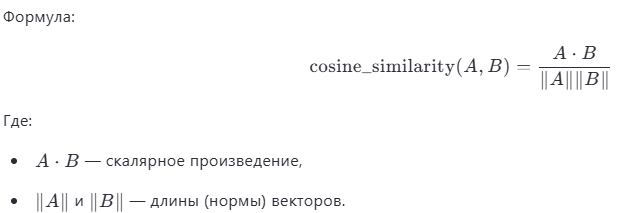
---
##### Какие эмбеддинги мы сравниваем?
1) Speaker Embedding:
   - Описывает тембр и звучание голоса.
   - Извлекается из специального спикер-энкодера.
   - Отвечает на вопрос: кто говорит?
2) GPT Conditioning Latent (gpt_cond_latent):
   - Описывает просодию : интонацию, темп, стиль речи.
   - Влияет на то, как говорится текст .
   - Может меняться в зависимости от контекста и модели.

##### Что мы сравниваем?
1) На сколько голос оригинала (женщина) отличается от голоса В.В. Путина при zero-shot клонировании?
2) Как меняется голос **Speaker Embedding** В.В. Путина после дообучения модели (zero-shot vs few-shot)?
3) Как меняется интонация/стиль речи **GPT Conditioning Latent** В.В. Путина после дообучения (zero-shot vs few-shot)?

In [148]:
try:
    logger.info(f"Загружаем все латентные состояния и эмбеддинги сгенерированных голосов")
    logger.info(f"Латентное состояние и сгенерированный голос оригинальной моделью на оригинальном голосе девушки (Zero-short)")
    zs_gpt_cond_latent_woman, zs_speaker_embedding_woman = ORIG_MODEL_TTS.get_conditioning_latents(audio_path=FINAL_VOICE_PATH)
    logger.info(f"Латентное состояние и сгенерированный голос оригинальной моделью на голосе В.В.Путина (Zero-short)")
    zs_gpt_cond_latent_putin, zs_speaker_embedding_putin = ORIG_MODEL_TTS.get_conditioning_latents(audio_path=ZS_FINAL_VOICE_PATH)
    logger.info(f"Латентное состояние и сгенерированный голос дообученной моделью на голосе В.В.Путина (Few-short)")
    fs_gpt_cond_latent_putin, fs_speaker_embedding_putin = FINE_MODEL_TTS.get_conditioning_latents(audio_path=FINE_FINAL_VOICE_PATH)
    logger.info(f"Все латентные состояния и эмбеддинги голосов загружены")
except Exception as e:
    logger.error(f"Ошибка при загрузки латентных состояний и эмбеддингов голосов: {e}")

2025-07-10 19:09:48,856 - __main__ - INFO - Загружаем все латентные состояния и эмбеддинги сгенерированных голосов
2025-07-10 19:09:48,858 - __main__ - INFO - Латентное состояние и сгенерированный голос оригинальной моделью на оригинальном голосе девушки (Zero-short)
2025-07-10 19:09:49,462 - __main__ - INFO - Латентное состояние и сгенерированный голос оригинальной моделью на голосе В.В.Путина (Zero-short)
2025-07-10 19:09:49,820 - __main__ - INFO - Латентное состояние и сгенерированный голос дообученной моделью на голосе В.В.Путина (Few-short)
2025-07-10 19:09:50,147 - __main__ - INFO - Все латентные состояния и эмбеддинги голосов загружены


In [149]:
def cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> float:
    """
    Вычисляет косинусное сходство между двумя векторами (тензорами PyTorch или массивами NumPy).

    Косинусное сходство измеряет угол между двумя векторами и не зависит от их длины.
    Значение находится в диапазоне [-1, 1], где:
        - 1 — векторы полностью совпадают по направлению,
        - 0 — ортогональные векторы,
        - -1 — противоположные направления.

    ### Параметры:
        a (torch.Tensor or np.ndarray): первый вектор
        b (torch.Tensor or np.ndarray): второй вектор

    ### Возвращаемое значение:
        float: косинусное сходство между векторами a и b

    ### Исключения:
        TypeError: если входные данные не являются torch.Tensor или np.ndarray
        ValueError: если размерности векторов не совпадают после преобразования
    """
    try:
        # Преобразуем тензоры в numpy массивы
        if isinstance(a, torch.Tensor):
            logger.debug("Преобразование первого аргумента из torch.Tensor в numpy.ndarray")
            a = a.cpu().numpy()  # Добавили .cpu()
        if isinstance(b, torch.Tensor):
            logger.debug("Преобразование второго аргумента из torch.Tensor в numpy.ndarray")
            b = b.cpu().numpy()  # Добавили .cpu()
        
        # Сравниваем размерности
        if a.shape != b.shape:
            logger.warning(f"Размерности векторов не совпадают: {a.shape} vs {b.shape}")
            raise ValueError(f"Векторы должны иметь одинаковую форму. Получено: {a.shape} и {b.shape}")

        # Выравниваем векторы
        a_flat = a.flatten()
        b_flat = b.flatten()

        # Вычисляем нормы
        norm_a = np.linalg.norm(a_flat)
        norm_b = np.linalg.norm(b_flat)

        if norm_a == 0 or norm_b == 0:
            logger.warning("Один из векторов является нулевым → невозможно вычислить косинусное сходство")
            return 0.0

        # Вычисление косинусного сходства
        dot_product = np.dot(a_flat, b_flat)
        similarity = dot_product / (norm_a * norm_b)

        logger.debug(f"Вычислено косинусное сходство: {similarity:.4f}")
        return similarity

    except Exception as e:
        logger.exception(f"Ошибка при вычислении косинусного сходства: {e}")
        raise

In [150]:
zs_woman_vs_zs_putin_emb = cosine_similarity(zs_speaker_embedding_woman, zs_speaker_embedding_putin)
zs_putin_vs_fs_putin_emb = cosine_similarity(zs_speaker_embedding_putin, fs_speaker_embedding_putin)
zs_putin_vs_fs_putin_latent = cosine_similarity(zs_gpt_cond_latent_putin, fs_gpt_cond_latent_putin)
logger.info(
    f"""Коссинусные расстояния на всем аудиофрагменте видео:
\nГолос оригинала (женщина) схож с голосом В.В. Путина при Zero-short клонировании на {zs_woman_vs_zs_putin_emb}
Голос В.В. Путина до (Zero-short) и после (Few-short) дообучения модели схож на {zs_putin_vs_fs_putin_emb}
Интонация/стиль речи В.В. Путина до (Zero-short) и после (Few-short) дообучения модели схожи на {zs_putin_vs_fs_putin_latent}""")

2025-07-10 19:09:50,289 - __main__ - INFO - Коссинусные расстояния на всем аудиофрагменте видео:

Голос оригинала (женщина) схож с голосом В.В. Путина при Zero-short клонировании на 0.2359948456287384
Голос В.В. Путина до (Zero-short) и после (Few-short) дообучения модели схож на 0.8250693082809448
Интонация/стиль речи В.В. Путина до (Zero-short) и после (Few-short) дообучения модели схожи на 0.6814418435096741


##### Что еще необходимо сравнить?
1) Остановимся на **Zero-short** клонировании голоса оригинальной моделью и **Few-short** клонировании голоса дообученной моделью **В.В. Путина**.
2) Обе финальные сгенерированные дорожки мы поделим на **сегменты** длительностью по **15 секунд**.
3) Для каждого сегмента мы будем получать **gpt_cond_latent** и **speaker_embedding**.
4) Расчитываем **косинусные расстояния** между сегментами по gpt_cond_latent и speaker_embedding.
5) Получим словарь тип **Dict[str, List[float]]**, в котором ключами будут *cos_gpt_cond_latent* и *cos_speaker_embedding*.
6) Построим *графики* и увидим пиковые значения где голос/интонация/стиль **похожи** и **не похожи** для ZS и FS генераций.

In [151]:
def split_audio_into_segments(
    audio_path: str,
    segment_length_ms: int = 15000,
    max_duration_ms: int = 300000  # 5 минут = 5 * 60 * 1000
) -> List[AudioSegment]:
    """
    Разбивает аудиофайл на сегменты заданной длины.
    Если файл превышает max_duration_ms, обрабатывается только его начало.

    Параметры:
        audio_path (str): путь к аудиофайлу.
        segment_length_ms (int): длина одного сегмента в миллисекундах.
        max_duration_ms (int): максимальная длительность аудио для обработки (в миллисекундах).

    Возвращает:
        List[AudioSegment]: список сегментов.
    """
    logger.info(f"Разделение аудио {audio_path} на сегменты по {segment_length_ms / 1000:.1f} сек")
    
    audio = AudioSegment.from_wav(audio_path)

    # Ограничиваем длину аудио до 5 минут
    if len(audio) > max_duration_ms:
        logger.info(f"Аудио длиннее 5 минут. Используется первые {max_duration_ms / 1000:.0f} секунд.")
        audio = audio[:max_duration_ms]

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        if len(segment) >= 1000:  # Минимум 1 секунда
            segments.append(segment)
        else:
            logger.warning(f"Сегмент короче 1 секунды — пропущен.")

    logger.info(f"Получено {len(segments)} сегментов.")
    return segments


def extract_embeddings_from_segments(
    model_tts,
    segments: List[AudioSegment],
    device: str = "cpu"
) -> Dict[str, List[np.ndarray]]:
    """
    Извлекает speaker_embedding и gpt_cond_latent из каждого сегмента.
    
    Параметры:
        model: модель XTTS.
        segments (List[AudioSegment]): список сегментов.
        device (str): устройство ('cuda' или 'cpu').
        
    Возвращает:
        Dict[str, List[np.ndarray]]: словарь с двумя списками эмбеддингов.
    """
    speaker_embeddings = []
    gpt_cond_latents = []

    for idx, seg in enumerate(segments):
        with NamedTemporaryFile(suffix=".wav", delete=True) as tmpfile:
            seg.export(tmpfile.name, format="wav")
            logger.info(f"[{idx}] Извлечение эмбеддингов из сегмента...")
            try:
                spk_emb, cond_lat = model_tts.get_conditioning_latents(audio_path=tmpfile.name)
                speaker_embeddings.append(spk_emb)
                gpt_cond_latents.append(cond_lat)
            except Exception as e:
                logger.error(f"[{idx}] Ошибка при извлечении эмбеддингов: {e}")
                continue

    return {
        "speaker_embeddings": speaker_embeddings,
        "gpt_cond_latents": gpt_cond_latents
    }


def compare_two_audios_with_models(
    zs_audio_path: str,
    fs_audio_path: str,
    zs_model,
    fs_model,
    segment_length_ms: int = 15000
) -> Dict[str, List[float]]:
    """
    Сравнивает два аудиофайла, обработанных разными моделями.
    Возвращает косинусные расстояния между сегментами.
    
    Параметры:
        zs_audio_path (str): путь к ZS-аудио.
        fs_audio_path (str): путь к FS-аудио.
        zs_model: модель Zero-Shot.
        fs_model: дообученная модель.
        segment_length_ms (int): длина сегмента в мс.
        
    Возвращает:
        dict_metrics = {
            'cos_speaker_emb': [...],
            'cos_gpt_cond_latent': [...]
        }
    """
    # Шаг 1: разделить оба аудио на сегменты
    zs_segments = split_audio_into_segments(zs_audio_path, segment_length_ms)
    fs_segments = split_audio_into_segments(fs_audio_path, segment_length_ms)

    min_len = min(len(zs_segments), len(fs_segments))
    if min_len == 0:
        logger.error("Нет подходящих сегментов для сравнения.")
        return {'cos_speaker_emb': [], 'cos_gpt_cond_latent': []}

    # Шаг 2: извлечь эмбеддинги
    logger.info("Извлечение эмбеддингов из ZS аудио...")
    zs_data = extract_embeddings_from_segments(zs_model, zs_segments)
    
    logger.info("Извлечение эмбеддингов из FS аудио...")
    fs_data = extract_embeddings_from_segments(fs_model, fs_segments)

    # Шаг 3: сравнить по сегментам
    cos_speaker_emb = []
    cos_gpt_cond_latent = []

    for i in range(min_len):
        sim_spk = cosine_similarity(zs_data["speaker_embeddings"][i], fs_data["speaker_embeddings"][i])
        sim_cond = cosine_similarity(zs_data["gpt_cond_latents"][i], fs_data["gpt_cond_latents"][i])

        cos_speaker_emb.append(sim_spk)
        cos_gpt_cond_latent.append(sim_cond)

        logger.info(f"Сегмент {i}:")
        logger.info(f"  Cosine similarity (Speaker Embedding): {sim_spk:.4f}")
        logger.info(f"  Cosine similarity (GPT Cond Latent): {sim_cond:.4f}")

    return {
        'cos_speaker_emb': cos_speaker_emb,
        'cos_gpt_cond_latent': cos_gpt_cond_latent
    }

In [152]:
ZS_FINAL_VOICE_PATH, FINE_FINAL_VOICE_PATH

('./data/output/zs_final_dubbing_putin.wav',
 './data/output/fine_final_dubbing_putin.wav')

In [153]:
dict_metrics = compare_two_audios_with_models(
    zs_audio_path=ZS_FINAL_VOICE_PATH,
    fs_audio_path=FINE_FINAL_VOICE_PATH,
    zs_model=ORIG_MODEL_TTS,
    fs_model=FINE_MODEL_TTS,
    segment_length_ms=15000, # 15 сегменты по 15 секунд
)

2025-07-10 19:09:51,983 - __main__ - INFO - Разделение аудио ./data/output/zs_final_dubbing_putin.wav на сегменты по 15.0 сек
2025-07-10 19:09:52,068 - __main__ - INFO - Аудио длиннее 5 минут. Используется первые 300 секунд.
2025-07-10 19:09:52,071 - __main__ - INFO - Получено 20 сегментов.
2025-07-10 19:09:52,072 - __main__ - INFO - Разделение аудио ./data/output/fine_final_dubbing_putin.wav на сегменты по 15.0 сек
2025-07-10 19:09:52,149 - __main__ - INFO - Аудио длиннее 5 минут. Используется первые 300 секунд.
2025-07-10 19:09:52,152 - __main__ - INFO - Получено 20 сегментов.
2025-07-10 19:09:52,152 - __main__ - INFO - Извлечение эмбеддингов из ZS аудио...
2025-07-10 19:09:52,154 - __main__ - INFO - [0] Извлечение эмбеддингов из сегмента...
2025-07-10 19:09:52,230 - __main__ - INFO - [1] Извлечение эмбеддингов из сегмента...
2025-07-10 19:09:52,301 - __main__ - INFO - [2] Извлечение эмбеддингов из сегмента...
2025-07-10 19:09:52,384 - __main__ - INFO - [3] Извлечение эмбеддингов из 

In [154]:
def plot_cosine_similarity(dict_metrics: Dict[str, List[float]], title_prefix: str = "") -> NoReturn:
    """
    Рисует два графика с косинусным расстоянием между эмбеддингами.
    
    Параметры:
        dict_metrics (Dict[str, List[float]]): словарь с метриками
            {
                'cos_speaker_emb': [значения],
                'cos_gpt_cond_latent': [значения]
            }
        title_prefix (str): префикс для заголовков графиков
        
    Возвращает:
        None
    """
    # Данные для графиков
    speaker_embeddings = dict_metrics['cos_speaker_emb']
    gpt_cond_latents = dict_metrics['cos_gpt_cond_latent']
    
    # Вычисляем статистики
    stats_speaker_emb = {
        "min": np.min(speaker_embeddings),
        "max": np.max(speaker_embeddings),
        "mean": np.mean(speaker_embeddings)
    }
    
    stats_gpt_cond_latent = {
        "min": np.min(gpt_cond_latents),
        "max": np.max(gpt_cond_latents),
        "mean": np.mean(gpt_cond_latents)
    }
    
    # График 1: Speaker Embeddings
    plt.figure(figsize=(10, 5))
    plt.plot(speaker_embeddings, marker='o', label='Косинусное расстояние')
    plt.title(f"{title_prefix} Схожесть по тембру (Speaker Embeddings)")
    plt.xlabel("Сегмент")
    plt.ylabel("Косинусное расстояние")
    plt.legend()
    
    # Добавляем текст с статистикой
    plt.text(0.5, 0.95, f"Минимальное: {stats_speaker_emb['min']:.4f}", transform=plt.gca().transAxes)
    plt.text(0.5, 0.9, f"Максимальное: {stats_speaker_emb['max']:.4f}", transform=plt.gca().transAxes)
    plt.text(0.5, 0.85, f"Cреднее: {stats_speaker_emb['mean']:.4f}", transform=plt.gca().transAxes)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # График 2: GPT Conditioning Latent
    plt.figure(figsize=(10, 5))
    plt.plot(gpt_cond_latents, marker='o', label='Косинусное расстояние')
    plt.title(f"{title_prefix} Схожесть по интонации (GPT Conditioning Latent)")
    plt.xlabel("Сегмент")
    plt.ylabel("Косинусное расстояние")
    plt.legend()
    
    # Добавляем текст с статистикой
    plt.text(0.5, 0.95, f"Минимальное: {stats_gpt_cond_latent['min']:.4f}", transform=plt.gca().transAxes)
    plt.text(0.5, 0.9, f"Максимальное: {stats_gpt_cond_latent['max']:.4f}", transform=plt.gca().transAxes)
    plt.text(0.5, 0.85, f"Cреднее: {stats_gpt_cond_latent['mean']:.4f}", transform=plt.gca().transAxes)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

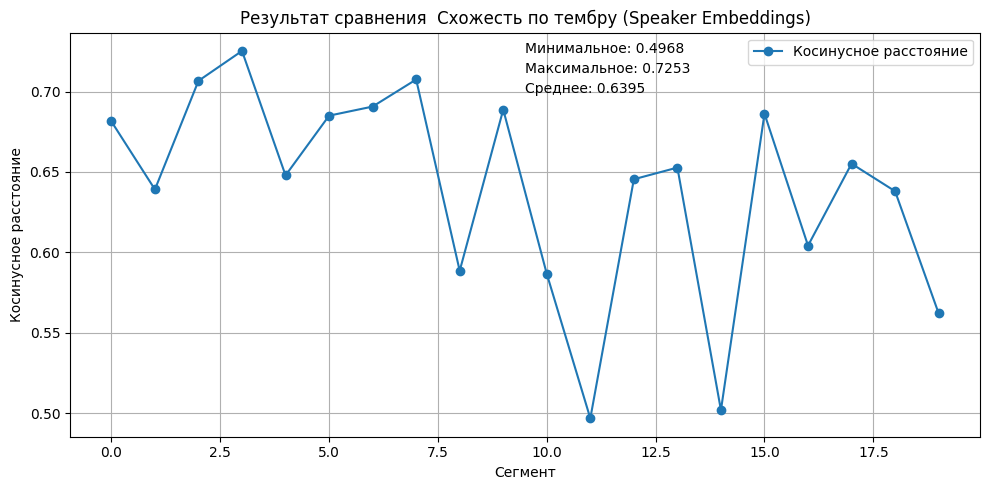

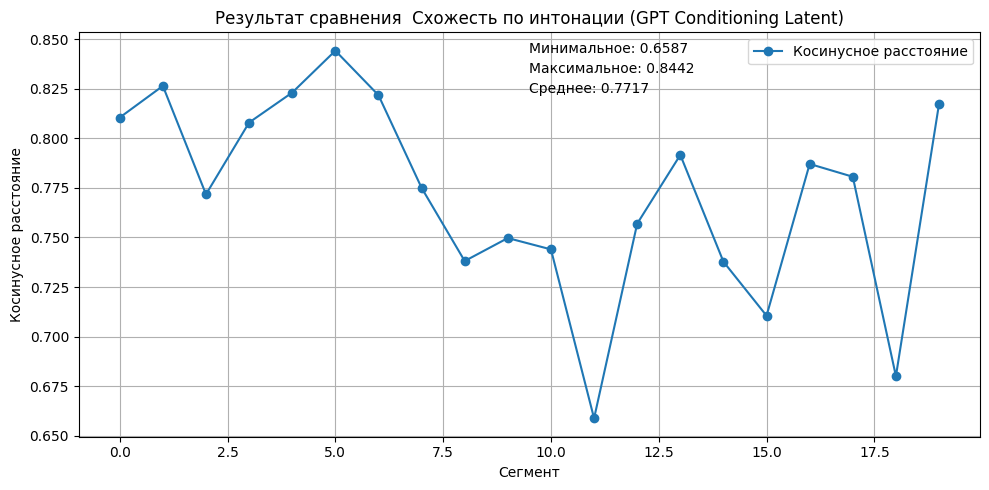

In [155]:
plot_cosine_similarity(dict_metrics, title_prefix="Результат сравнения ")

##### Для чистоты эксперимента!
1) Остановимся на **Zero-short** клонировании голоса оригинальной моделью и **Few-short** клонировании голоса дообученной моделью **В.В. Путина**.
2) Возьмем несколько случайных и независимых по времени сегментов в течение выступления.
3) Сгенерируем для них чистые записи двух моделей.
4) Расчитаем косинусные расстояния и провизуализируем.

In [156]:
def select_random_segments(segments: List[Dict],
                           count: int = 10,
                           min_duration: float = 6.0,
                           max_duration: float = 12.0) -> List[str]:
    """
    Выбирает случайные сегменты заданной длины.

    Параметры:
        segments (List[Dict]): исходный список сегментов.
        count (int): количество сегментов для выборки.
        min_duration (float): минимальная длительность сегмента (в секундах).
        max_duration (float): максимальная длительность сегмента (в секундах).

    Возвращает:
        List[Dict]: список случайно выбранных сегментов.
    """
    # Шаг 1: фильтруем сегменты по длительности
    filtered_segments = [
        seg for seg in segments
        if min_duration <= seg.get("corrected_duration_sec", 0) <= max_duration
    ]
    
    logger.info(f"Найдено {len(filtered_segments)} сегментов продолжительностью от {min_duration} до {max_duration} секунд")

    # Шаг 2: проверяем, достаточно ли сегментов
    if len(filtered_segments) < count:
        logger.warning(f"Требуется {count} сегментов, но найдено всего {len(filtered_segments)}. "
                       f"Будет возвращено {len(filtered_segments)}")
        return filtered_segments
    
    # Шаг 3: выбираем случайные сегменты
    selected_segments = random.sample(filtered_segments, count)
    logger.info(f"Выбрано {len(selected_segments)} случайных сегментов")

    result_list = [x['text'] for x in selected_segments]

    return result_list

In [164]:
random_sentences = select_random_segments(segments=translated_segments)
random_sentences

2025-07-10 19:12:10,709 - __main__ - INFO - Найдено 24 сегментов продолжительностью от 6.0 до 12.0 секунд
2025-07-10 19:12:10,710 - __main__ - INFO - Выбрано 10 случайных сегментов


['Раньше это было ежеквартально, потом ежемесячно, но теперь я практикую это еженедельно.',
 'Представляя себе кого-то, кого я восхищаю в своей роли, задавая себе вопрос, что такое, что тот человек, которого я восхищаю, сделал бы иначе, чтобы улучшить ситуацию,',
 'Итак, вопрос в том, какие методы или практики могут помочь нам преодолеть проблемы, которые мешают нам достичь уверенности и роста.',
 'Так часто вокруг нас есть люди, которые просто ждут, чтобы мы предприняли действия, сделали то, что мы хотели,',
 'Каждую воскресенье в 13:00, когда у моих детей сейчас пять и семь были НАПС, РИ-П НАПС,',
 'Когда мне было девять лет, моя мама подошла ко мне и сказала: "Это все, я закончила, мы уезжаем".',
 'Я ушел, и я просто смотрю на тебя в своей роли, и я спрашиваю, что в первую очередь ты бы сделал иначе, если бы я не был в этом.',
 'Эта практика изменила мою жизнь, и я верю, что она изменит вашу, если вы примените ее.',
 'И однажды я услышала от консультанта ресторана, что иногда стоит 

In [165]:
random_sentences = ['Раньше это было ежеквартально, потом ежемесячно, но теперь я практикую это еженедельно.',
 'Представляя себе кого-то, кого я восхищаю в своей роли, задавая себе вопрос, что такое, что тот человек, которого я восхищаю, сделал бы иначе, чтобы улучшить ситуацию,',
 'Итак, вопрос в том, какие методы или практики могут помочь нам преодолеть проблемы, которые мешают нам достичь уверенности и роста.',
 'Так часто вокруг нас есть люди, которые просто ждут, чтобы мы предприняли действия, сделали то, что мы хотели,',
 'Каждую воскресенье в 13:00, когда у моих детей сейчас пять и семь были НАПС, РИ-П НАПС,',
 'Когда мне было девять лет, моя мама подошла ко мне и сказала: "Это все, я закончила, мы уезжаем".',
 'Я ушел, и я просто смотрю на тебя в своей роли, и я спрашиваю, что в первую очередь ты бы сделал иначе, если бы я не был в этом.',
 'Эта практика изменила мою жизнь, и я верю, что она изменит вашу, если вы примените ее.',
 'И однажды я услышала от консультанта ресторана, что иногда стоит представить себе кого-то другого в своей роли, чтобы помочь мотивировать вас к действию.',
 'Я отправляю электронную почту, планирую рейс, запускаю его, а потом, когда он запускается, сообщаю команде.']


In [166]:
def generate_embeddings_for_poetry(
    zs_model,
    fs_model,
    speaker_wav_path: str,
    texts: List[str],
    language: str = "ru"
) -> Dict[str, List[float]]:
    """
    Генерирует аудио из списка текстов и сравнивает эмбеддинги Zero-Shot и Few-Shot моделей.

    Возвращает:
        dict_metrics = {
            'cos_speaker_emb': [...],
            'cos_gpt_cond_latent': [...]
        }
    """
    cos_speaker_emb = []
    cos_gpt_cond_latent = []

    for idx, text in enumerate(texts):
        logger.info(f"\nГенерация для текста {idx + 1}:")
        clean_text = re.sub(r'[^\w\s.,—–]', '', text).strip()
        if not clean_text:
            logger.warning(f"[{idx}] Текст стал пустым после очистки → пропущен.")
            continue

        # --- Генерируем аудио ---
        with NamedTemporaryFile(suffix=".wav", delete=True) as tmpfile:
            # Zero-Shot
            logger.info(f"[{idx}] Генерация Zero-Shot...")
            zs_gpt_cond_latent, zs_speaker_embedding = zs_model.get_conditioning_latents(audio_path=speaker_wav_path)
            zsp_audio = zs_model.inference(text=clean_text,
                                           language=language,
                                           speaker_embedding=zs_speaker_embedding,
                                           gpt_cond_latent=zs_gpt_cond_latent)
            
            sf.write(tmpfile.name, zsp_audio["wav"], 24000)
            zs_spk_emb, zs_cond_lat = zs_model.get_conditioning_latents(audio_path=tmpfile.name)

            # Few-Shot
            logger.info(f"[{idx}] Генерация Few-Shot...")
            fs_gpt_cond_latent, fs_speaker_embedding = fs_model.get_conditioning_latents(audio_path=speaker_wav_path)
            fsp_audio = fs_model.inference(text=clean_text,
                                           language=language,
                                           speaker_embedding=zs_speaker_embedding,
                                           gpt_cond_latent=zs_gpt_cond_latent)
            
            sf.write(tmpfile.name, fsp_audio["wav"], 24000)
            fs_spk_emb, fs_cond_lat = fs_model.get_conditioning_latents(audio_path=tmpfile.name)

            # --- Вычисляем схожесть ---
            sim_spk = cosine_similarity(zs_spk_emb, fs_spk_emb)
            sim_cond = cosine_similarity(zs_cond_lat, fs_cond_lat)

            cos_speaker_emb.append(sim_spk)
            cos_gpt_cond_latent.append(sim_cond)

            logger.info(f"[{idx}] Cos(Speaker Embedding): {sim_spk:.4f}")
            logger.info(f"[{idx}] Cos(GPT Cond Latent): {sim_cond:.4f}")

    return {
        "cos_speaker_emb": cos_speaker_emb,
        "cos_gpt_cond_latent": cos_gpt_cond_latent
    }

In [167]:
dict_metrics_for_random_sentences = generate_embeddings_for_poetry(
    zs_model=ORIG_MODEL_TTS,
    fs_model=FINE_MODEL_TTS,
    speaker_wav_path=speaker_ref,
    texts=random_sentences,
    language=LANGUAGE
)

2025-07-10 19:12:21,279 - __main__ - INFO - 
Генерация для текста 1:
2025-07-10 19:12:21,280 - __main__ - INFO - [0] Генерация Zero-Shot...
2025-07-10 19:12:25,191 - __main__ - INFO - [0] Генерация Few-Shot...
2025-07-10 19:12:31,698 - __main__ - INFO - [0] Cos(Speaker Embedding): 0.7169
2025-07-10 19:12:31,698 - __main__ - INFO - [0] Cos(GPT Cond Latent): 0.7495
2025-07-10 19:12:31,699 - __main__ - INFO - 
Генерация для текста 2:
2025-07-10 19:12:31,700 - __main__ - INFO - [1] Генерация Zero-Shot...
2025-07-10 19:12:37,637 - __main__ - INFO - [1] Генерация Few-Shot...
2025-07-10 19:12:43,522 - __main__ - INFO - [1] Cos(Speaker Embedding): 0.7447
2025-07-10 19:12:43,523 - __main__ - INFO - [1] Cos(GPT Cond Latent): 0.7855
2025-07-10 19:12:43,524 - __main__ - INFO - 
Генерация для текста 3:
2025-07-10 19:12:43,525 - __main__ - INFO - [2] Генерация Zero-Shot...
2025-07-10 19:12:48,414 - __main__ - INFO - [2] Генерация Few-Shot...
2025-07-10 19:12:54,972 - __main__ - INFO - [2] Cos(Speake

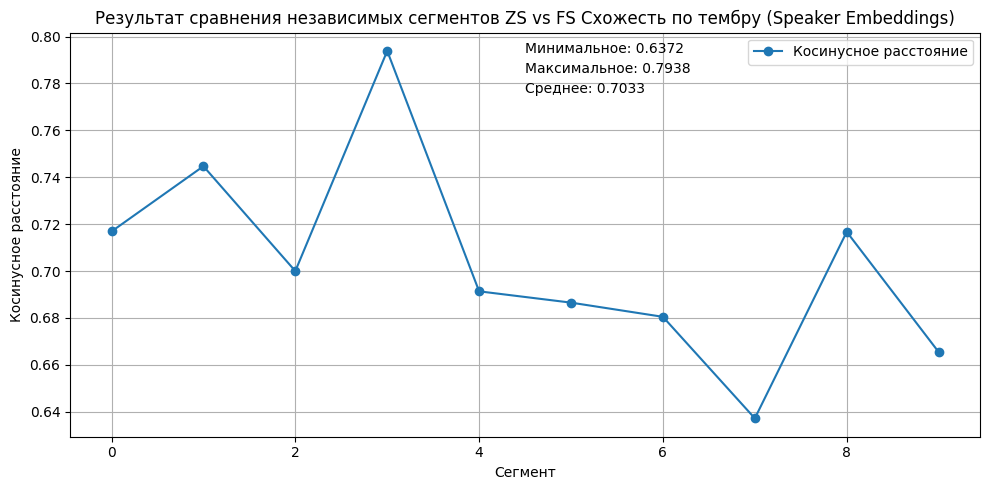

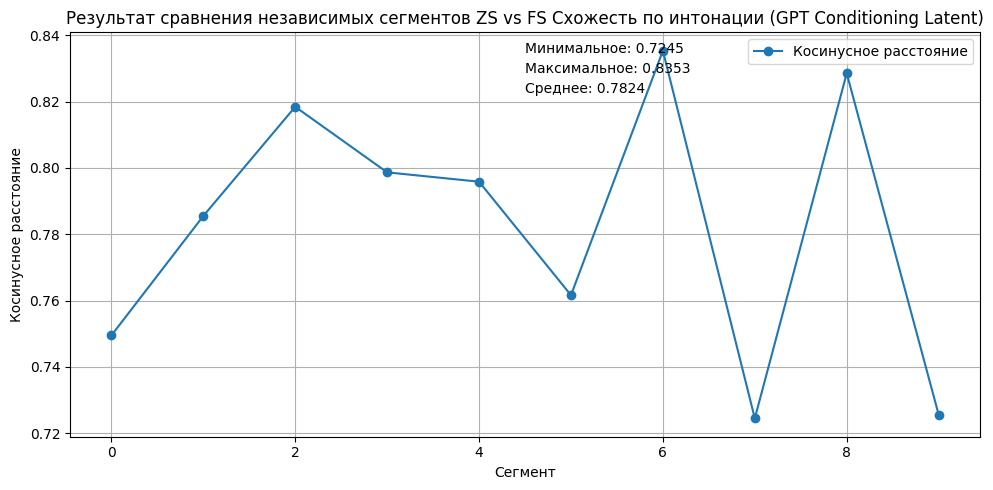

In [168]:
plot_cosine_similarity(dict_metrics_for_random_sentences, title_prefix="Результат сравнения независимых сегментов ZS vs FS")

---
#### Итоги по анализу метрик:
1) Косинусное расстояние **Speaker Embedding** сегментов из цельно-сгенерированных аудиодорожек (15 секунд):
   - min=0.4968
   - max=0.7253
   - avg= 0.6395
2) Косинусное расстояние **GPT Cond Latent** сегментов из цельно-сгенерированных аудиодорожек (15 секунд):
   - min=0.6587
   - max=0.8442
   - avg= 0.7717
---
1) Косинусное расстояние **Speaker Embedding** 10 случайных сегментов из текста выступления (6-12 секунд):
   - min=0.6372
   - max=0.7938
   - avg= 0.7033
2) Косинусное расстояние **GPT Cond Latent** 10 случайных сегментов из текста выступления (6-12 секунд):
   - min=0.7245
   - max=0.8353
   - avg= 0.7824
---
* Можно сделать вывод, что схожесть интонаций, темпа и стиля речи (**GPT Conditioning Latent**) между ZS и FS клонированием выше, чем тембр и звучание голос спикера (**Speaker Embedding**). Видно что модель дообучилась и отдалила эмббединги и латентные состояния спикера, сгенерированная речь на дообученной модели более естественна и похожа на голос клонируемого спикера.

# Итоги по проекту:

* Данный проект представляет собой современный, гибкий и масштабируемый пайплайн для автоматического дублирования видео с английского на русский язык, с хорошим качеством и потенциалом для развития. Он использует самые актуальные технологии в области:
    - Source Separation (Demucs),
    - ASR (Whisper),
    - MT (NLLB),
    - TTS (XTTS-v2),
    - Voice Cloning (Zero/Few-shot + Fine-tuning).
* И может применяться в таких сферах как:
    - Образование (перевод лекций),
    - Медиа (локализация видеоконтента),
    - Корпоративные системы (дублирование тренингов и презентаций),
    - Персонализация голосового контента (например, для медицинских или финансовых сервисов).
---
### Возможные улучшения и развитие
1. Улучшение синхронизации
    - Внедрить Forced Alignment через Montreal Forced Aligner (MFA) .
    - Это позволит точно выравнивать сгенерированные сегменты по времени.
2. Более точный перевод
    - Использовать слайдинг-оконный перевод с учётом контекста.
    - Или fine-tuned NLLB / BART на парах "английский → русский".
3. Клонирование голоса через VITS
    - Модель VITS обеспечивает более естественную речь.
    - Требует обучения, но качество может быть выше, чем у XTTS.
4. Персонализация через fine-tuning
    - Дообучение модели на разнообразных примерах голоса (быстрая/медленная речь, вопросы, повелительные формы и т.д.).
    - Это улучшит стабильность интонаций и уменьшит различия между сегментами.
---
На текущий момент данный проект интегрирован в TG-бота **https://t.me/@VideoDubTimBot**, в котором можно воспользоваться следующим функционалом:
1) **Видео дубляж** - синхронный перевод с английского на русский язык для видео <20мб (ограничения сервера общего пользования Telegram API) с возможностью выбора голоса:
    - Оригинальный спикер (Zero-short клонирование);
    - Дообученная модель с голосом В.В. Путина (Few-short клонирование);
    - Ваш голос, который необходимо записать в обратном сообщении (Zero-short клонирование).
2) **Видео / аудио транскрипция** - получение транскрибированного текста из видео <20мб или голосового сообщения;
3) **Видео / текст перевод** - получение переведенного текста с англиского на русский из видео <20мб или любого текстового сообщения. **Исправил** историю с переводом по сегментам и перед переводом напарвляю объединенный текст после транскрипции (качество перевода выросло);
4) **Озвучка текста** - можно озвучить любой текст и получить голосовое сообщение с возможностью выбора голоса:
    - Дообученная модель с голосом В.В. Путина (Few-short клонирование);
    - Ваш голос, который необходимо записать в обратном сообщении (Zero-short клонирование).